In [1]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
import warnings
warnings.filterwarnings('ignore')
from empyrical import max_drawdown,cum_returns_final,cum_returns,sortino_ratio,sharpe_ratio,calmar_ratio,annual_return,annual_volatility

import matplotlib.pyplot as plt

import time
import datetime as dt
from datetime import timedelta
from pytz import timezone

import yfinance as yf
from datetime import date
import itertools as it

In [2]:
from platform import python_version

print(python_version())

3.7.4


# LOAD DATA V1

In [3]:
import_path = '/Users/niclaswolnerhanssen/Desktop/LINC/Sentiment LYNX/2_SIGNAL_PROCESSING/'

V1_TWITTER_ZSCORED                      = pd.read_excel(
    import_path+'V1_TWITTER_ZSCORED.xlsx',index_col=0)
V1_REDDIT_ZSCORED                       = pd.read_excel(
    import_path+'V1_REDDIT_ZSCORED.xlsx',index_col=0)
V1_BLOOMBERG_ZSCORED                    = pd.read_excel(
    import_path+'V1_BLOOMBERG_ZSCORED.xlsx',index_col=0)
V1_TWITTER_REDDIT_ZSCORED               = pd.read_excel(
    import_path+'V1_TWITTER_REDDIT_ZSCORED.xlsx',index_col=0)
V1_TWITTER_REDDIT_BLOOMBERG_ZSCORED     = pd.read_excel(
    import_path+'V1_TWITTER_REDDIT_BLOOMBERG_ZSCORED.xlsx',index_col=0)
V1_EMA_ZSCORED                          = pd.read_excel(
    import_path+'V1_EMA_ZSCORED.xlsx',index_col=0)
V1_EMA_TWITTER_ZSCORED                  = pd.read_excel(
    import_path+'V1_EMA_TWITTER_ZSCORED.xlsx',index_col=0)
V1_EMA_REDDIT_ZSCORED                   = pd.read_excel(
    import_path+'V1_EMA_REDDIT_ZSCORED.xlsx',index_col=0)
V1_EMA_BLOOMBERG_ZSCORED                = pd.read_excel(
    import_path+'V1_EMA_BLOOMBERG_ZSCORED.xlsx',index_col=0)
V1_EMA_TWITTER_REDDIT_ZSCORED           = pd.read_excel(
    import_path+'V1_EMA_TWITTER_REDDIT_ZSCORED.xlsx',index_col=0)
V1_EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED = pd.read_excel(
    import_path+'V1_EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED.xlsx',index_col=0)
OPEN_TO_CLOSE_STOCK_RETURNS             = pd.read_excel(
    import_path+'V1_OPEN_TO_CLOSE_STOCK_RETURNS.xlsx',index_col=0)
OPEN_TO_CLOSE_EQUALW_RETURNS            = pd.read_excel(
    import_path+'V1_OPEN_TO_CLOSE_EQUALW_RETURNS.xlsx',index_col=0)
OPEN_TO_CLOSE_XLK_RETURNS               = pd.read_excel(
    import_path+'V1_OPEN_TO_CLOSE_XLK_RETURNS.xlsx',index_col=0)
OPEN_TO_OPEN_STOCK_RETURNS              = pd.read_excel(
    import_path+'V1_OPEN_TO_OPEN_STOCK_RETURNS.xlsx',index_col=0)
OPEN_TO_OPEN_EQUALW_RETURNS             = pd.read_excel(
    import_path+'V1_OPEN_TO_OPEN_EQUALW_RETURNS.xlsx',index_col=0)
OPEN_TO_OPEN_XLK_RETURNS                = pd.read_excel(
    import_path+'V1_OPEN_TO_OPEN_XLK_RETURNS.xlsx',index_col=0)



In [4]:
signal_df_list = [

V1_TWITTER_ZSCORED,
V1_REDDIT_ZSCORED,
V1_BLOOMBERG_ZSCORED,
V1_EMA_ZSCORED,
V1_TWITTER_REDDIT_ZSCORED,
V1_TWITTER_REDDIT_BLOOMBERG_ZSCORED,
V1_EMA_TWITTER_ZSCORED,
V1_EMA_REDDIT_ZSCORED,
V1_EMA_BLOOMBERG_ZSCORED,
V1_EMA_TWITTER_REDDIT_ZSCORED,
V1_EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED
    
 ]

# FUNCTIONS

In [5]:
def backtest_minmax(signal_df,returns_df,upper_q=0.5,lower_q = 0.5,min_stocks_each_basket = 1,extra_weight = 0.2):
    signal_df['RETURNS'] = returns_df['STOCK_RETURNS']
    #create date list
    date_list = signal_df['Date'].unique()
    feat_name = signal_df.columns[2]
    
    DATES = []
    TRADE_DATES = []
    MKT_NEUTRAL_RETURNS = []
    LONG_RETURNS = []
    SHORT_RETURNS = []
    DIAGNOSTICS = []
    
    
    for i in date_list:
        date_df = signal_df[signal_df['Date']==i]

        #create seperat long/short dfs by quantile
        long_date_df  = date_df[date_df[feat_name]>date_df.quantile(q=upper_q)[0]]
        short_date_df = date_df[date_df[feat_name]<date_df.quantile(q=lower_q)[0]]
        
        #There must be more stocks than min_stocks in each basket to trade 
        if (len(long_date_df)<min_stocks_each_basket)|(len(short_date_df)<min_stocks_each_basket):
            NO_VALUES = True

        else:
            NO_VALUES = False

        if NO_VALUES == True:
            DATES.append(i)
            MKT_NEUTRAL_RETURNS.append(0) 
            continue
        
        if len(long_date_df)==1:
            ONLY_1_LONG = True
        else:
            ONLY_1_LONG = False
            
        if len(short_date_df)==1:
            ONLY_1_SHORT = True 
        else:
            ONLY_1_SHORT = False
            
            
        ########WEIGHTS
        
        #SHORT
        short_date_df['MIN-MAX'] = ((short_date_df[feat_name]*-1) - (short_date_df[feat_name]*-1).min())/(
                                    (short_date_df[feat_name]*-1).max() - (short_date_df[feat_name]*-1).min())

        short_date_df['MIN-MAX'] = short_date_df['MIN-MAX']+extra_weight
        short_date_df['MIN-MAX-WEIGHT'] = short_date_df['MIN-MAX']/short_date_df['MIN-MAX'].sum()
        short_date_df['LONG/SHORT MULTIPLIER'] = np.ones(len(short_date_df))*-1

        #LONG
        long_date_df['MIN-MAX'] = ((long_date_df[feat_name]) - (long_date_df[feat_name]).min())/(
                                    (long_date_df[feat_name]).max() - (long_date_df[feat_name]).min())
        long_date_df['MIN-MAX'] = long_date_df['MIN-MAX']+extra_weight
        long_date_df['MIN-MAX-WEIGHT'] = long_date_df['MIN-MAX']/long_date_df['MIN-MAX'].sum()
        long_date_df['LONG/SHORT MULTIPLIER'] = np.ones(len(long_date_df)) 
        
        ########RETURNS
        
        if ONLY_1_LONG==True:
            long_date_df['WEIGHTED RETURNS']  = 0.5*long_date_df['RETURNS'] *long_date_df['LONG/SHORT MULTIPLIER']
        else:
            long_date_df['WEIGHTED RETURNS']  = 0.5*long_date_df['RETURNS'] *long_date_df['LONG/SHORT MULTIPLIER'] *long_date_df['MIN-MAX-WEIGHT']

        if ONLY_1_SHORT==True:
            short_date_df['WEIGHTED RETURNS'] = 0.5*short_date_df['RETURNS']*short_date_df['LONG/SHORT MULTIPLIER']
        else:
            short_date_df['WEIGHTED RETURNS'] = 0.5*short_date_df['RETURNS']*short_date_df['LONG/SHORT MULTIPLIER']*short_date_df['MIN-MAX-WEIGHT']

                
        ######APPEND
        
        #only on trading days (if min_stock is fulfilled)
        long_returns_date_sum = long_date_df['WEIGHTED RETURNS'].sum()#append
        LONG_RETURNS.append(long_returns_date_sum)
        
        short_returns_date_sum = short_date_df['WEIGHTED RETURNS'].sum()#append
        SHORT_RETURNS.append(short_returns_date_sum)
        
        total_returns_date_sum = long_returns_date_sum+short_returns_date_sum#append
        MKT_NEUTRAL_RETURNS.append(total_returns_date_sum)
        
        diagnostics_df = pd.concat([long_date_df,short_date_df]).sort_index()#append
        DIAGNOSTICS.append(diagnostics_df)
        
        TRADE_DATES.append(i)
        DATES.append(i)
        
    ##########pile to dfs
    
    STRATEGY_RETURNS            = pd.DataFrame(index=DATES)
    STRATEGY_RETURNS[feat_name] = MKT_NEUTRAL_RETURNS
    
    LS_RETURNS = pd.DataFrame(index=TRADE_DATES)
    LS_RETURNS[feat_name+'_LONG_RETURNS']  = LONG_RETURNS
    LS_RETURNS[feat_name+'_SHORT_RETURNS'] = SHORT_RETURNS
    
    #LS_returns only includes when returns when trading, so cumulative rets are going to be wrong, lets fix:
    LS_RETURNS = pd.concat([STRATEGY_RETURNS,LS_RETURNS],axis=1)
    LS_RETURNS = LS_RETURNS.drop(feat_name,axis=1)
    LS_RETURNS = LS_RETURNS.replace(np.nan,0)
    
    DIAGNOSTICS_DF = pd.concat(DIAGNOSTICS)
    
    return STRATEGY_RETURNS, LS_RETURNS, DIAGNOSTICS_DF
    
    

In [6]:
def backtest_rank(signal_df,returns_df,upper_q=0.5,lower_q = 0.5,min_stocks_each_basket = 1):
    signal_df['RETURNS'] = returns_df['STOCK_RETURNS']
    #create date list
    date_list = signal_df['Date'].unique()
    feat_name = signal_df.columns[2]
    
    DATES = []
    TRADE_DATES = []
    MKT_NEUTRAL_RETURNS = []
    LONG_RETURNS = []
    SHORT_RETURNS = []
    DIAGNOSTICS = []
    
    
    for i in date_list:
        date_df = signal_df[signal_df['Date']==i]

        #create seperat long/short dfs by quantile
        long_date_df  = date_df[date_df[feat_name]>date_df.quantile(q=upper_q)[0]]
        short_date_df = date_df[date_df[feat_name]<date_df.quantile(q=lower_q)[0]]
        
        #There must be more stocks than min_stocks in each basket to trade 
        if (len(long_date_df)<min_stocks_each_basket)|(len(short_date_df)<min_stocks_each_basket):
            NO_VALUES = True

        else:
            NO_VALUES = False

        if NO_VALUES==True:
            DATES.append(i)
            MKT_NEUTRAL_RETURNS.append(0) 
            continue
            
        ######## RANK WEIGHTS
        
        #SHORT
        short_date_df['ZSCORE RANK'] = short_date_df[feat_name].mul(-1).rank()
        short_date_df['RANK-WEIGHT'] = short_date_df['ZSCORE RANK']/short_date_df['ZSCORE RANK'].sum()
        short_date_df['LONG/SHORT MULTIPLIER'] = np.ones(len(short_date_df))*-1

        #LONG
        long_date_df['ZSCORE RANK'] = long_date_df[feat_name].rank()
        long_date_df['RANK-WEIGHT'] = long_date_df['ZSCORE RANK']/long_date_df['ZSCORE RANK'].sum()
        long_date_df['LONG/SHORT MULTIPLIER'] = np.ones(len(long_date_df))  
        
        ########RETURNS
        
        long_date_df['WEIGHTED RETURNS']  = 0.5*long_date_df['RETURNS'] *long_date_df['LONG/SHORT MULTIPLIER'] *long_date_df['RANK-WEIGHT']
        short_date_df['WEIGHTED RETURNS'] = 0.5*short_date_df['RETURNS']*short_date_df['LONG/SHORT MULTIPLIER']*short_date_df['RANK-WEIGHT']
    
        ######APPEND
        
        #only on trading days (if min_stock is fulfilled)
        long_returns_date_sum = long_date_df['WEIGHTED RETURNS'].sum()#append
        LONG_RETURNS.append(long_returns_date_sum)
        
        short_returns_date_sum = short_date_df['WEIGHTED RETURNS'].sum()#append
        SHORT_RETURNS.append(short_returns_date_sum)
        
        total_returns_date_sum = long_returns_date_sum+short_returns_date_sum#append
        MKT_NEUTRAL_RETURNS.append(total_returns_date_sum)
        
        diagnostics_df = pd.concat([long_date_df,short_date_df]).sort_index()#append
        DIAGNOSTICS.append(diagnostics_df)
        
        TRADE_DATES.append(i)
        DATES.append(i)
        
    ##########pile to dfs
    
    STRATEGY_RETURNS            = pd.DataFrame(index=DATES)
    STRATEGY_RETURNS[feat_name] = MKT_NEUTRAL_RETURNS
    
    LS_RETURNS = pd.DataFrame(index=TRADE_DATES)
    LS_RETURNS[feat_name+'_LONG_RETURNS']  = LONG_RETURNS
    LS_RETURNS[feat_name+'_SHORT_RETURNS'] = SHORT_RETURNS
    
    #LS_returns only includes when returns when trading, so cumulative rets are going to be wrong, lets fix:
    LS_RETURNS = pd.concat([STRATEGY_RETURNS,LS_RETURNS],axis=1)
    LS_RETURNS = LS_RETURNS.drop(feat_name,axis=1)
    LS_RETURNS = LS_RETURNS.replace(np.nan,0)
    
    DIAGNOSTICS_DF = pd.concat(DIAGNOSTICS)
    
    return STRATEGY_RETURNS, LS_RETURNS, DIAGNOSTICS_DF
    
    

In [7]:
def backtest_metrics(df):
    
    annualization=250       
    
    df_list = []
    for i in df.columns:
        df_series_ret = df[i]
        
        df_met = pd.DataFrame(index=['CAGR','Ann. Vol','Cumulative Ret.','MDD','Sharpe Ratio','Sortino Ratio','Calmar Ratio'])
        annual_ret = str( round(annual_return(df_series_ret,annualization=annualization)*100,2))+'%'
        annual_vol = str( round(annual_volatility(df_series_ret,annualization=annualization)*100,2))+'%'
        cum_ret = str( round(cum_returns_final(df_series_ret)*100,2))+'%'
        mdd= str( round(max_drawdown(df_series_ret)*100,2))+'%'
        sharpe = str( round(sharpe_ratio(df_series_ret,annualization=annualization),2))
        sort = str( round(sortino_ratio(df_series_ret,annualization=annualization),2))
        calmar = str( round(calmar_ratio(df_series_ret,annualization=annualization),2))

        df_met[df_series_ret.name] = [annual_ret,annual_vol,cum_ret,mdd,sharpe,sort,calmar]
        df_met = df_met.T
        df_list.append(df_met)
    
    df_2 = pd.concat(df_list)
    
    return df_2


In [8]:
def nr_of_trading_days(STRATEGY_RETURNS):
    NR_OF_ZERO_RETURNS_DAYS = len(STRATEGY_RETURNS[STRATEGY_RETURNS[STRATEGY_RETURNS.columns[0]]==0])
    NR_OF_DAYS = len(STRATEGY_RETURNS)

    return print('Nr of Trading Days, '+STRATEGY_RETURNS.columns[0]+' :'+str(round(100*(1-(NR_OF_ZERO_RETURNS_DAYS/NR_OF_DAYS)),2))+'%')


In [9]:
def total_number_of_trading_stocks(DIAGNOSTICS_DF):
    total = len(DIAGNOSTICS_DF['Stock'].unique())
    return print('Total Nr of stocks trading, '+DIAGNOSTICS_DF.columns[2]+': '+ str(total))

In [10]:
def stats_long_short(DIAGNOSTICS_DF):
    feat_name = DIAGNOSTICS_DF.columns[2]

    LONG_PORTFOLIOS = DIAGNOSTICS_DF[DIAGNOSTICS_DF['LONG/SHORT MULTIPLIER']==1]
    SHORT_PORTFOLIOS = DIAGNOSTICS_DF[DIAGNOSTICS_DF['LONG/SHORT MULTIPLIER']==-1]

    Long_holdings = []
    for i in LONG_PORTFOLIOS['Date'].unique():
        nr_of_long_holdings_per_trading_day = len(LONG_PORTFOLIOS[LONG_PORTFOLIOS['Date']==i])
        Long_holdings.append(nr_of_long_holdings_per_trading_day)

    Short_holdings = []
    for i in SHORT_PORTFOLIOS['Date'].unique():
        nr_of_short_holdings_per_trading_day = len(SHORT_PORTFOLIOS[SHORT_PORTFOLIOS['Date']==i])
        Short_holdings.append(nr_of_short_holdings_per_trading_day)

    Long_mean = np.mean(Long_holdings)
    Long_min  = np.min(Long_holdings)
    Long_max  = np.max(Long_holdings)

    Short_mean = np.mean(Short_holdings)
    Short_min  = np.min(Short_holdings)
    Short_max  = np.max(Short_holdings)

    df = pd.DataFrame(index=['MEAN','MIN','MAX'])
    df['LONG BASKET NR. HOLDINGS, '+feat_name] = [Long_mean,Long_min,Long_max]
    df['SHORT BASKET NR. HOLDING, '+feat_name] = [Short_mean,Short_min,Short_max]
    return df


In [11]:
def top_10_stocks_traded(DIAGNOSTICS_DF):
    feat_name = DIAGNOSTICS_DF.columns[2]
    LONG_PORTFOLIOS = DIAGNOSTICS_DF[DIAGNOSTICS_DF['LONG/SHORT MULTIPLIER']==1]
    SHORT_PORTFOLIOS = DIAGNOSTICS_DF[DIAGNOSTICS_DF['LONG/SHORT MULTIPLIER']==-1]
    
    #LONG BASKET
    LONG_ALLOCATION_NAME = []
    LONG_ALLOCATION_PERC = []
    for i in LONG_PORTFOLIOS['Stock'].unique():
        trade_days = len(LONG_PORTFOLIOS[LONG_PORTFOLIOS['Stock']==i])
        long_days = len(LONG_PORTFOLIOS['Date'].unique())
        ratio = (trade_days/long_days)*100
        ratio = round(ratio,2)
        LONG_ALLOCATION_NAME.append(i)
        LONG_ALLOCATION_PERC.append(ratio)

    df_long = pd.DataFrame(index=LONG_ALLOCATION_NAME)
    df_long [feat_name+' LONG %'] = LONG_ALLOCATION_PERC
    df_long            = df_long.sort_values(feat_name+' LONG %',ascending=False)
    df_long            = df_long.iloc[0:10,]
    
    #SHORT BASKET
    SHORT_ALLOCATION_NAME = []
    SHORT_ALLOCATION_PERC = []
    for i in SHORT_PORTFOLIOS['Stock'].unique():
        trade_days = len(SHORT_PORTFOLIOS[SHORT_PORTFOLIOS['Stock']==i])
        short_days = len(SHORT_PORTFOLIOS['Date'].unique())
        ratio = (trade_days/short_days)*100
        ratio = round(ratio,2)
        SHORT_ALLOCATION_NAME.append(i)
        SHORT_ALLOCATION_PERC.append(ratio)

    df_short = pd.DataFrame(index=SHORT_ALLOCATION_NAME)
    df_short [feat_name+' SHORT %'] = SHORT_ALLOCATION_PERC
    df_short            = df_short.sort_values(feat_name+' SHORT %',ascending=False)
    df_short            = df_short.iloc[0:10,]
    
    #DISPLAY STUFF
    
    from IPython.display import display_html
    from itertools import chain,cycle
    def display_side_by_side(*args,titles=cycle([''])):
        html_str=''
        for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
            html_str+='<th style="text-align:center"><td style="vertical-align:top">'
            html_str+=f'<h2>{title}</h2>'
            html_str+=df.to_html().replace('table','table style="display:inline"')
            html_str+='</td></th>'
        display_html(html_str,raw=True)
        
    return display_side_by_side(df_long,df_short)
    

In [12]:
def turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='YES'):
    
    ###In percentage terms how many stocks are replaced on average each day in the basket?
    ### if ALL_DAYS='YES', calculate all based on all trading days, else just calculate when trading
    
    if BASKET=='LONG':
        DIRECTION = 1
    else:
        DIRECTION = -1

    stocks_in_basket_list = []
    
    if ALL_DAYS=='YES':

        for i in STRATEGY_RETURNS.index:

                DIA = DIAGNOSTICS_DF[DIAGNOSTICS_DF['Date']==i]
                DIA_LONG = DIA[DIA['LONG/SHORT MULTIPLIER']==DIRECTION]
                STOCKS_IN_T0 = DIA_LONG['Stock'].values
                stocks_in_basket_list.append(STOCKS_IN_T0)
                
                
    else:
        
        for i in DIAGNOSTICS_DF['Date'].unique():

                DIA = DIAGNOSTICS_DF[DIAGNOSTICS_DF['Date']==i]
                DIA_LONG = DIA[DIA['LONG/SHORT MULTIPLIER']==DIRECTION]
                STOCKS_IN_T0 = DIA_LONG['Stock'].values
                stocks_in_basket_list.append(STOCKS_IN_T0)
        


    turnover_percent = []
    for i in range(0,len(stocks_in_basket_list)):
        if i != len(stocks_in_basket_list)-1:
            nr_stocks_in_t0 = len(stocks_in_basket_list[i])
            nr_stocks_in_t1 = len(stocks_in_basket_list[i+1])

            #if there is no stocks in first period but stock in next, the turnover is 100% for that day
            if (nr_stocks_in_t0 == 0)&(nr_stocks_in_t1!=0):
                percentage_of_stocks_new_in_t1 = 1.0
            #if there is no stocks in second period but stock in period before, the turnover is 100% for that day
            elif (nr_stocks_in_t0 !=0)&(nr_stocks_in_t1==0):
                percentage_of_stocks_new_in_t1 = 1.0       

            else:
                #nr of intersected stocks
                nr_stocks_from_t0_still_in_t1 = len(list(set(stocks_in_basket_list[i]) & set(stocks_in_basket_list[i+1])))
                nr_total_stocks_in_t1 = len(stocks_in_basket_list[i+1])

                if nr_total_stocks_in_t1 != 0:
                    percentage_of_stocks_new_in_t1 = 1-(nr_stocks_from_t0_still_in_t1/nr_total_stocks_in_t1)
                else:
                    percentage_of_stocks_new_in_t1 = 0


            turnover_percent.append(percentage_of_stocks_new_in_t1)  

    mean_turnover = round(np.mean(turnover_percent),2)
    
    if BASKET=='LONG':
        if ALL_DAYS=='YES':
            string = 'Mean Turnover, Long Basket, All days, '+DIAGNOSTICS_DF.columns[2]+': '+str(mean_turnover)
            
        else:
            string = 'Mean Turnover, Long Basket, trading days only, '+DIAGNOSTICS_DF.columns[2]+': '+str(mean_turnover)
    else:
        if ALL_DAYS=='YES':
            string = 'Mean Turnover, Short Basket, All days, '+DIAGNOSTICS_DF.columns[2]+': '+str(mean_turnover)
            
        else:
            string = 'Mean Turnover, Short Basket, trading days only, '+DIAGNOSTICS_DF.columns[2]+': '+str(mean_turnover)

    return print(string)

    

# OPEN TO CLOSE

In [13]:
upper_q = 0.5
lower_q = 0.5
min_stocks_each_basket = 1
extra_weight = 0.2 # in min-max weighting due to min value is removed from the lowest value, 
                   #making the smallest value having zero weight which is a problem
                   # when the number of stocks in each basket is small.
        
returns_df = OPEN_TO_CLOSE_STOCK_RETURNS.copy()

# ZSCORE WEIGHTED

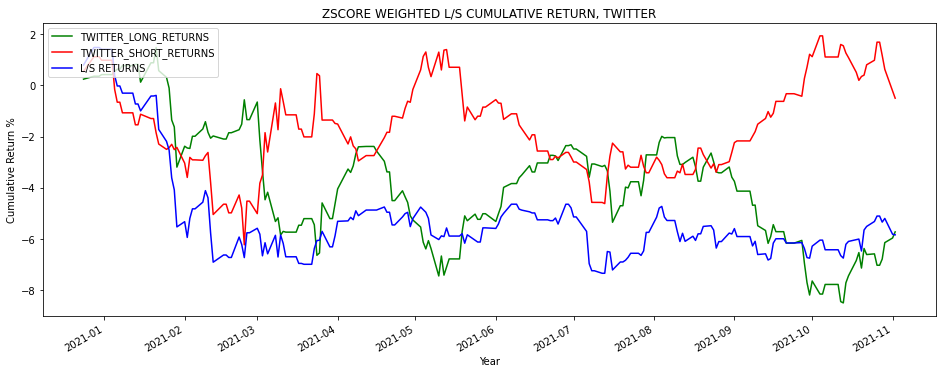

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
TWITTER_LONG_RETURNS    -6.6%    7.88%          -5.73%  -9.84%        -0.83   
TWITTER_SHORT_RETURNS  -0.57%    8.27%           -0.5%  -7.27%        -0.03   
L/S RETURNS            -6.73%    6.57%          -5.84%   -8.7%        -1.03   

                      Sortino Ratio Calmar Ratio  
TWITTER_LONG_RETURNS          -1.08        -0.67  
TWITTER_SHORT_RETURNS         -0.04        -0.08  
L/S RETURNS                   -1.32        -0.77

Nr of Trading Days, TWITTER :75.93%
Total Nr of stocks trading, TWITTER: 24


TWITTER LONG % 
 
 
 
 
 MSFT 
 54.88 
 
 
 QCOM 
 53.05 
 
 
 AAPL 
 51.22 
 
 
 ADP 
 50.00 
 
 
 LRCX 
 49.39 
 
 
 INTC 
 42.68 
 
 
 CSCO 
 42.68 
 
 
 TER 
 41.46 
 
 
 NVDA 
 40.85 
 
 
 ADI 
 35.98 
 
 
 
 
 
 
 TWITTER SHORT % 
 
 
 
 
 NVDA 
 53.66 
 
 
 INTC 
 53.05 
 
 
 ADBE 
 51.22 
 
 
 PYPL 
 49.39 
 
 
 TER 
 46.95 
 
 
 ADP 
 46.34 
 
 
 AAPL 
 44.51 
 
 
 MSFT 
 42.07 
 
 
 ADI 
 40.24 
 
 
 CRM 
 36.59

Mean Turnover, Long Basket, All days, TWITTER: 0.45
Mean Turnover, Short Basket, All days, TWITTER: 0.44
Mean Turnover, Long Basket, trading days only, TWITTER: 0.17
Mean Turnover, Short Basket, trading days only, TWITTER: 0.16


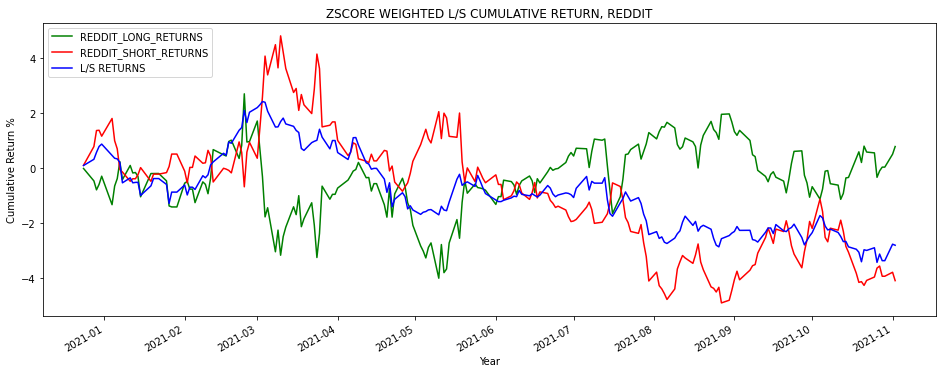

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
REDDIT_LONG_RETURNS    0.91%    8.97%           0.79%  -6.52%         0.15   
REDDIT_SHORT_RETURNS  -4.71%    8.14%          -4.09%  -9.26%        -0.55   
L/S RETURNS           -3.23%    4.39%           -2.8%  -5.71%        -0.73   

                     Sortino Ratio Calmar Ratio  
REDDIT_LONG_RETURNS            0.2         0.14  
REDDIT_SHORT_RETURNS         -0.77        -0.51  
L/S RETURNS                  -0.97        -0.57

Nr of Trading Days, REDDIT :95.83%
Total Nr of stocks trading, REDDIT: 50


REDDIT LONG % 
 
 
 
 
 FTNT 
 77.78 
 
 
 MSI 
 57.97 
 
 
 INTC 
 53.14 
 
 
 CRM 
 52.66 
 
 
 TER 
 51.69 
 
 
 AMD 
 51.69 
 
 
 AVGO 
 51.21 
 
 
 ENPH 
 51.21 
 
 
 TDY 
 50.72 
 
 
 MU 
 50.24 
 
 
 
 
 
 
 REDDIT SHORT % 
 
 
 
 
 ADP 
 62.32 
 
 
 PYPL 
 59.42 
 
 
 AAPL 
 56.52 
 
 
 CSCO 
 56.04 
 
 
 HPE 
 55.07 
 
 
 LRCX 
 53.62 
 
 
 WDC 
 53.62 
 
 
 IBM 
 52.66 
 
 
 ORCL 
 52.17 
 
 
 XLNX 
 50.72

Mean Turnover, Long Basket, All days, REDDIT: 0.22
Mean Turnover, Short Basket, All days, REDDIT: 0.22
Mean Turnover, Long Basket, trading days only, REDDIT: 0.17
Mean Turnover, Short Basket, trading days only, REDDIT: 0.17


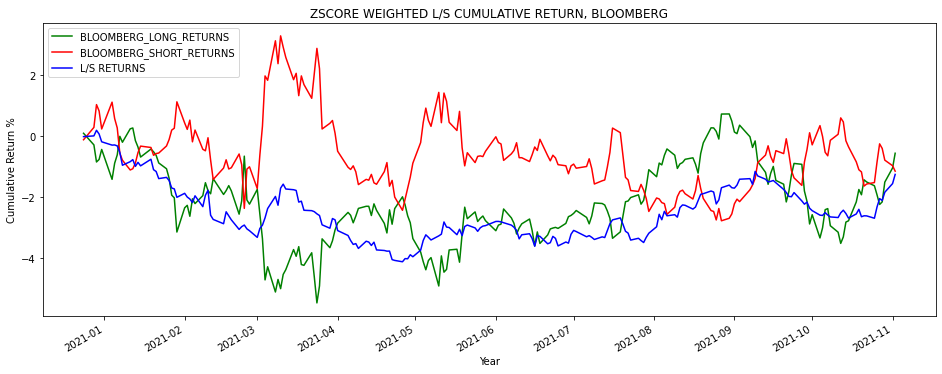

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
BLOOMBERG_LONG_RETURNS   -0.64%    7.31%          -0.55%  -5.73%        -0.05   
BLOOMBERG_SHORT_RETURNS  -1.32%    7.76%          -1.14%  -5.88%        -0.13   
L/S RETURNS              -1.44%     3.1%          -1.25%  -4.31%        -0.45   

                        Sortino Ratio Calmar Ratio  
BLOOMBERG_LONG_RETURNS          -0.07        -0.11  
BLOOMBERG_SHORT_RETURNS         -0.19        -0.22  
L/S RETURNS                     -0.64        -0.34

Nr of Trading Days, BLOOMBERG :100.0%
Total Nr of stocks trading, BLOOMBERG: 75


BLOOMBERG LONG % 
 
 
 
 
 MA 
 58.80 
 
 
 ENPH 
 58.33 
 
 
 FTNT 
 57.87 
 
 
 V 
 55.56 
 
 
 NVDA 
 55.09 
 
 
 NOW 
 54.63 
 
 
 TER 
 53.70 
 
 
 FISV 
 53.24 
 
 
 INTU 
 53.24 
 
 
 INTC 
 53.24 
 
 
 
 
 
 
 BLOOMBERG SHORT % 
 
 
 
 
 ANSS 
 57.41 
 
 
 KEYS 
 56.48 
 
 
 JKHY 
 55.09 
 
 
 BR 
 54.63 
 
 
 PTC 
 54.63 
 
 
 ADSK 
 54.63 
 
 
 NLOK 
 54.17 
 
 
 HPE 
 53.24 
 
 
 IPGP 
 53.24 
 
 
 TEL 
 53.24

Mean Turnover, Long Basket, All days, BLOOMBERG: 0.19
Mean Turnover, Short Basket, All days, BLOOMBERG: 0.2
Mean Turnover, Long Basket, trading days only, BLOOMBERG: 0.19
Mean Turnover, Short Basket, trading days only, BLOOMBERG: 0.2


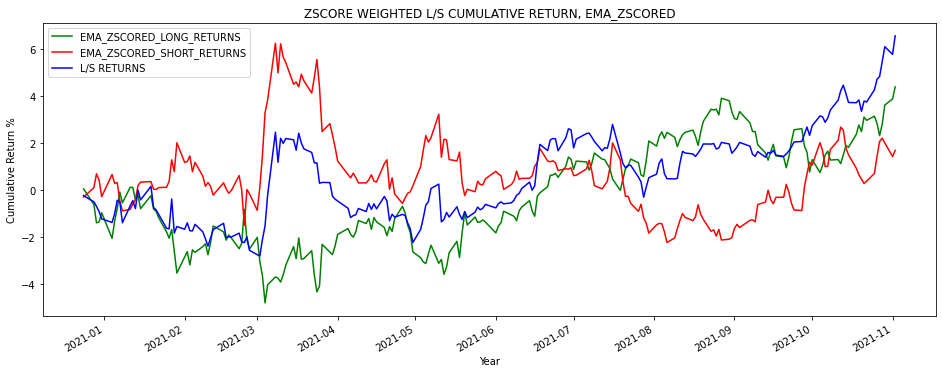

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_ZSCORED_LONG_RETURNS   5.11%    7.78%            4.4%  -4.92%   
EMA_ZSCORED_SHORT_RETURNS  1.97%    8.89%            1.7%  -7.98%   
L/S RETURNS                7.65%    7.23%           6.57%  -4.58%   

                          Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_ZSCORED_LONG_RETURNS          0.68           1.0         1.04  
EMA_ZSCORED_SHORT_RETURNS         0.26          0.39         0.25  
L/S RETURNS                       1.06          1.62         1.67

Nr of Trading Days, EMA_ZSCORED :100.0%
Total Nr of stocks trading, EMA_ZSCORED: 75


EMA_ZSCORED LONG % 
 
 
 
 
 FTNT 
 77.31 
 
 
 INTU 
 66.67 
 
 
 MPWR 
 64.35 
 
 
 IT 
 62.96 
 
 
 KEYS 
 60.65 
 
 
 ZBRA 
 59.26 
 
 
 SNPS 
 59.26 
 
 
 CRM 
 58.80 
 
 
 ANSS 
 58.33 
 
 
 NVDA 
 58.33 
 
 
 
 
 
 
 EMA_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 64.81 
 
 
 WU 
 64.81 
 
 
 GPN 
 62.50 
 
 
 FIS 
 62.50 
 
 
 FISV 
 62.50 
 
 
 GLW 
 61.57 
 
 
 CTSH 
 61.11 
 
 
 FLT 
 61.11 
 
 
 IBM 
 59.72 
 
 
 AKAM 
 59.26

Mean Turnover, Long Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_ZSCORED: 0.19


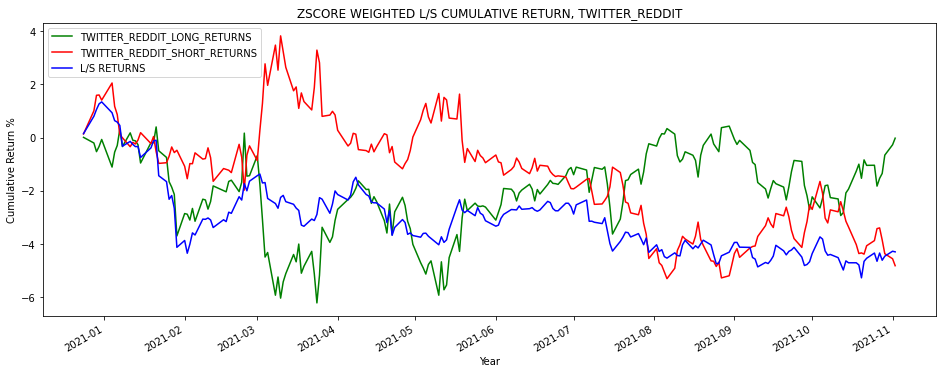

CAGR Ann. Vol Cumulative Ret.     MDD  \
TWITTER_REDDIT_LONG_RETURNS   -0.02%    9.43%          -0.02%  -6.59%   
TWITTER_REDDIT_SHORT_RETURNS  -5.56%    8.33%          -4.82%   -8.8%   
L/S RETURNS                   -4.96%    5.15%           -4.3%  -6.53%   

                             Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_LONG_RETURNS          0.04          0.06         -0.0  
TWITTER_REDDIT_SHORT_RETURNS        -0.64          -0.9        -0.63  
L/S RETURNS                         -0.96         -1.24        -0.76

Nr of Trading Days, TWITTER_REDDIT :100.0%
Total Nr of stocks trading, TWITTER_REDDIT: 52


TWITTER_REDDIT LONG % 
 
 
 
 
 FTNT 
 64.35 
 
 
 CRM 
 53.70 
 
 
 TER 
 53.24 
 
 
 MSFT 
 50.93 
 
 
 AMD 
 49.07 
 
 
 SWKS 
 49.07 
 
 
 BR 
 49.07 
 
 
 MU 
 48.61 
 
 
 NVDA 
 48.61 
 
 
 INTC 
 47.22 
 
 
 
 
 
 
 TWITTER_REDDIT SHORT % 
 
 
 
 
 ORCL 
 57.41 
 
 
 ADP 
 56.94 
 
 
 PYPL 
 55.56 
 
 
 IBM 
 52.31 
 
 
 AAPL 
 51.85 
 
 
 INTC 
 51.85 
 
 
 WDC 
 49.54 
 
 
 QCOM 
 49.54 
 
 
 MSFT 
 49.07 
 
 
 ADBE 
 49.07

Mean Turnover, Long Basket, All days, TWITTER_REDDIT: 0.24
Mean Turnover, Short Basket, All days, TWITTER_REDDIT: 0.21
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT: 0.24
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT: 0.21


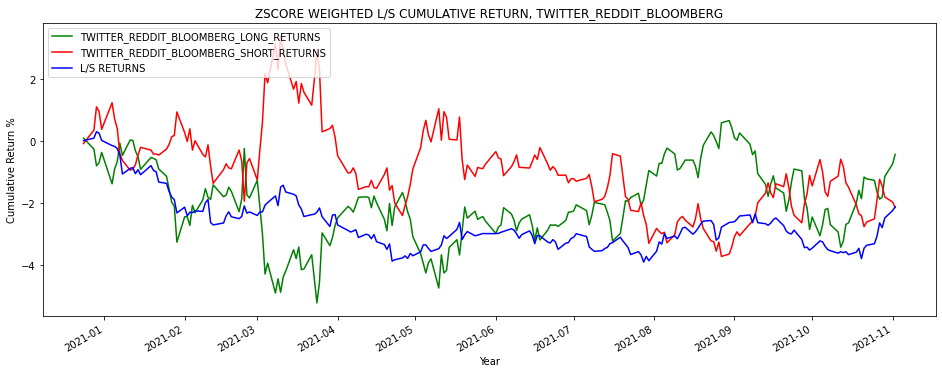

CAGR Ann. Vol Cumulative Ret.  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS    -0.5%    7.57%          -0.43%   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -2.47%    7.68%          -2.14%   
L/S RETURNS                             -2.45%     3.1%          -2.12%   

                                           MDD Sharpe Ratio Sortino Ratio  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS   -5.31%        -0.03         -0.04   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -6.88%        -0.29         -0.41   
L/S RETURNS                             -4.19%        -0.78         -1.02   

                                       Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS         -0.09  
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS        -0.36  
L/S RETURNS                                   -0.58

Nr of Trading Days, TWITTER_REDDIT_BLOOMBERG :100.0%
Total Nr of stocks trading, TWITTER_REDDIT_BLOOMBERG: 75


TWITTER_REDDIT_BLOOMBERG LONG % 
 
 
 
 
 FTNT 
 62.96 
 
 
 TER 
 58.33 
 
 
 AVGO 
 57.87 
 
 
 QCOM 
 57.87 
 
 
 MA 
 57.41 
 
 
 MSFT 
 56.02 
 
 
 SWKS 
 55.56 
 
 
 NXPI 
 55.56 
 
 
 V 
 55.09 
 
 
 NOW 
 55.09 
 
 
 
 
 
 
 TWITTER_REDDIT_BLOOMBERG SHORT % 
 
 
 
 
 PAYX 
 58.80 
 
 
 TRMB 
 58.80 
 
 
 KEYS 
 58.33 
 
 
 ADP 
 57.41 
 
 
 ADSK 
 56.94 
 
 
 ANSS 
 56.94 
 
 
 NLOK 
 56.48 
 
 
 BR 
 56.02 
 
 
 WDC 
 55.56 
 
 
 PTC 
 55.09

Mean Turnover, Long Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Short Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.21


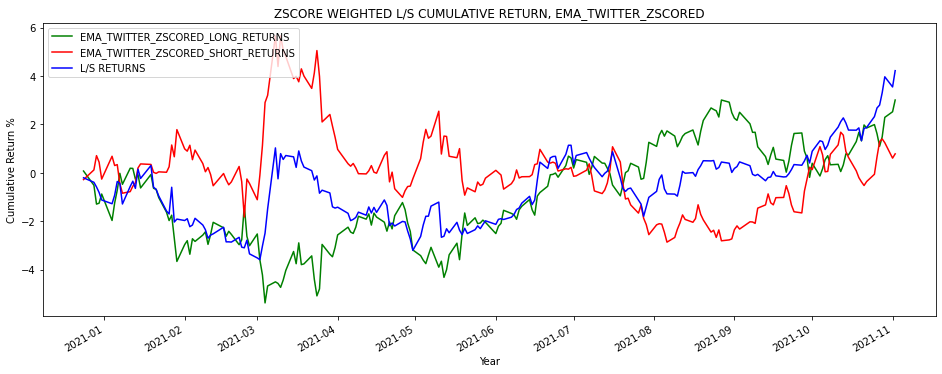

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_TWITTER_ZSCORED_LONG_RETURNS   3.49%    7.78%           3.01%  -5.55%   
EMA_TWITTER_ZSCORED_SHORT_RETURNS  0.91%    8.76%           0.78%  -8.07%   
L/S RETURNS                         4.9%    6.83%           4.22%  -4.19%   

                                  Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_TWITTER_ZSCORED_LONG_RETURNS          0.48           0.7         0.63  
EMA_TWITTER_ZSCORED_SHORT_RETURNS         0.15          0.22         0.11  
L/S RETURNS                               0.73           1.1         1.17

Nr of Trading Days, EMA_TWITTER_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_ZSCORED: 75


EMA_TWITTER_ZSCORED LONG % 
 
 
 
 
 FTNT 
 76.85 
 
 
 MPWR 
 65.28 
 
 
 INTU 
 65.28 
 
 
 IT 
 62.50 
 
 
 KEYS 
 61.57 
 
 
 SNPS 
 60.65 
 
 
 CDNS 
 59.26 
 
 
 ANSS 
 58.80 
 
 
 MSI 
 58.33 
 
 
 CDW 
 57.87 
 
 
 
 
 
 
 EMA_TWITTER_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 64.35 
 
 
 WU 
 62.50 
 
 
 GPN 
 62.04 
 
 
 FISV 
 62.04 
 
 
 FIS 
 61.57 
 
 
 QCOM 
 60.65 
 
 
 FLT 
 60.19 
 
 
 GLW 
 59.72 
 
 
 CTSH 
 59.72 
 
 
 INTC 
 58.33

Mean Turnover, Long Basket, All days, EMA_TWITTER_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_TWITTER_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_ZSCORED: 0.2


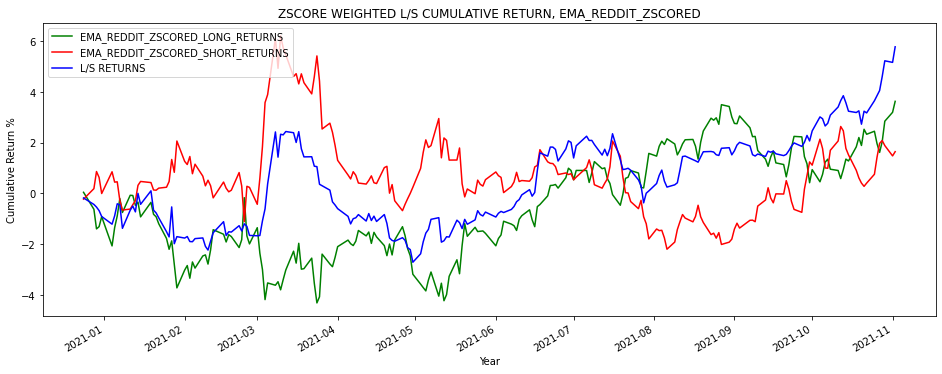

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_REDDIT_ZSCORED_LONG_RETURNS   4.21%    7.93%           3.63%  -4.35%   
EMA_REDDIT_ZSCORED_SHORT_RETURNS  1.91%     8.5%           1.64%  -7.91%   
L/S RETURNS                       6.71%    6.12%           5.77%  -5.02%   

                                 Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_REDDIT_ZSCORED_LONG_RETURNS          0.56          0.82         0.97  
EMA_REDDIT_ZSCORED_SHORT_RETURNS         0.26          0.39         0.24  
L/S RETURNS                              1.09          1.67         1.34

Nr of Trading Days, EMA_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_REDDIT_ZSCORED: 75


EMA_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 74.07 
 
 
 IT 
 65.28 
 
 
 MPWR 
 64.81 
 
 
 NVDA 
 60.19 
 
 
 ANSS 
 60.19 
 
 
 INTU 
 59.26 
 
 
 ADBE 
 58.33 
 
 
 SNPS 
 57.87 
 
 
 CDNS 
 57.41 
 
 
 CDW 
 56.94 
 
 
 
 
 
 
 EMA_REDDIT_ZSCORED SHORT % 
 
 
 
 
 FISV 
 67.59 
 
 
 FLT 
 64.35 
 
 
 CSCO 
 63.89 
 
 
 CTXS 
 63.43 
 
 
 FIS 
 62.04 
 
 
 GPN 
 61.57 
 
 
 WDC 
 61.11 
 
 
 WU 
 60.65 
 
 
 CTSH 
 60.19 
 
 
 ADP 
 60.19

Mean Turnover, Long Basket, All days, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_REDDIT_ZSCORED: 0.19


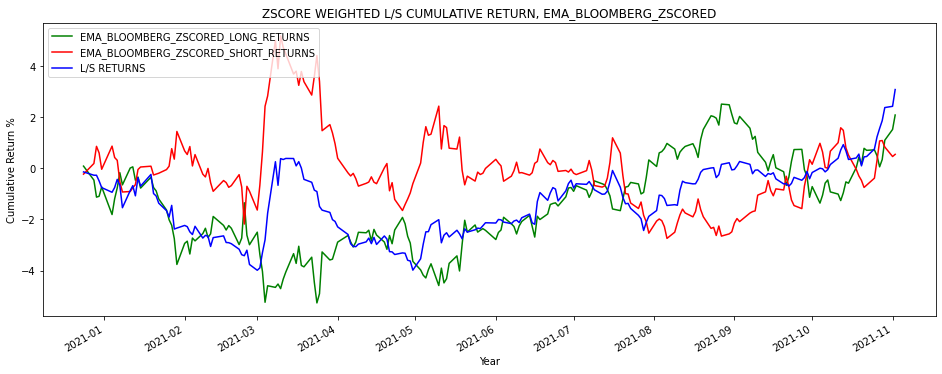

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS   2.42%    7.45%           2.08%  -5.35%   
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS  0.63%     8.6%           0.55%  -7.53%   
L/S RETURNS                          3.57%     5.5%           3.08%  -4.35%   

                                    Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS          0.36          0.52         0.45  
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS         0.12          0.17         0.08  
L/S RETURNS                                 0.67          1.06         0.82

Nr of Trading Days, EMA_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_BLOOMBERG_ZSCORED: 75


EMA_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 70.37 
 
 
 IT 
 61.11 
 
 
 MPWR 
 60.19 
 
 
 INTU 
 59.26 
 
 
 XLNX 
 56.94 
 
 
 CDW 
 56.94 
 
 
 CDNS 
 56.02 
 
 
 CDAY 
 55.56 
 
 
 NVDA 
 55.09 
 
 
 NOW 
 55.09 
 
 
 
 
 
 
 EMA_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 60.19 
 
 
 CTSH 
 58.80 
 
 
 GPN 
 58.33 
 
 
 INTC 
 56.02 
 
 
 AKAM 
 55.56 
 
 
 FLT 
 55.56 
 
 
 MA 
 55.09 
 
 
 HPQ 
 55.09 
 
 
 IBM 
 54.63 
 
 
 CSCO 
 54.17

Mean Turnover, Long Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2


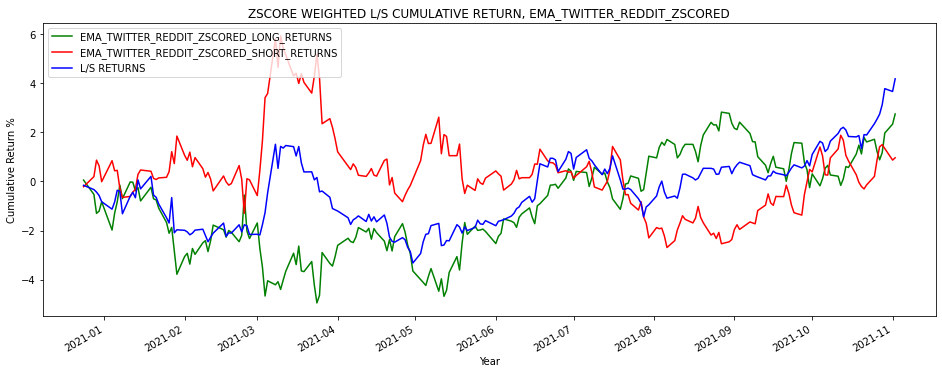

CAGR Ann. Vol Cumulative Ret.  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS   3.19%    7.94%           2.75%   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  1.12%    8.44%           0.97%   
L/S RETURNS                               4.86%    5.93%           4.19%   

                                             MDD Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS   -5.01%         0.44          0.63   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  -8.15%         0.17          0.26   
L/S RETURNS                               -4.77%         0.83          1.25   

                                         Calmar Ratio  
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS          0.64  
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS         0.14  
L/S RETURNS                                      1.02

Nr of Trading Days, EMA_TWITTER_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_ZSCORED: 75


EMA_TWITTER_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 74.07 
 
 
 MPWR 
 65.28 
 
 
 IT 
 64.35 
 
 
 INTU 
 60.65 
 
 
 ANSS 
 60.19 
 
 
 SNPS 
 59.26 
 
 
 NVDA 
 59.26 
 
 
 CDNS 
 58.80 
 
 
 HPQ 
 58.80 
 
 
 KEYS 
 58.33 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_ZSCORED SHORT % 
 
 
 
 
 FISV 
 67.13 
 
 
 FLT 
 65.28 
 
 
 ADP 
 63.43 
 
 
 CTXS 
 63.43 
 
 
 FIS 
 62.04 
 
 
 GPN 
 61.57 
 
 
 WU 
 60.65 
 
 
 WDC 
 60.65 
 
 
 CTSH 
 59.72 
 
 
 CSCO 
 59.72

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.19


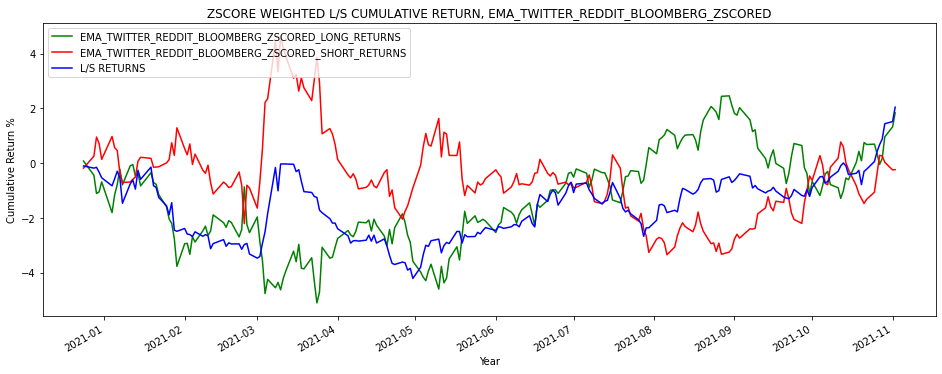

CAGR Ann. Vol  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS    2.13%    7.59%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS  -0.27%     8.3%   
L/S RETURNS                                          2.37%     5.0%   

                                                   Cumulative Ret.     MDD  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS            1.84%  -5.18%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS          -0.23%  -7.64%   
L/S RETURNS                                                  2.05%  -4.21%   

                                                   Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS          0.32          0.46   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS         0.01          0.01   
L/S RETURNS                                                0.49          0.76   

                                                   Calmar Ratio  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS          0.41  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS        -0.04  
L/S RETURNS                                                0.56

Nr of Trading Days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 75


EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 73.15 
 
 
 IT 
 62.96 
 
 
 MPWR 
 61.11 
 
 
 AVGO 
 57.41 
 
 
 NVDA 
 56.94 
 
 
 TER 
 56.48 
 
 
 CDW 
 56.48 
 
 
 MSFT 
 55.56 
 
 
 CDAY 
 55.56 
 
 
 CDNS 
 55.09 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 ADP 
 62.04 
 
 
 CTSH 
 61.11 
 
 
 CTXS 
 60.65 
 
 
 WDC 
 60.19 
 
 
 FLT 
 58.80 
 
 
 FISV 
 58.33 
 
 
 GPN 
 58.33 
 
 
 IBM 
 56.94 
 
 
 WU 
 55.56 
 
 
 FFIV 
 55.09

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2


In [14]:
zscore_returns = []

for i in signal_df_list:
    
    STRATEGY_RETURNS, LS_RETURNS, DIAGNOSTICS_DF = backtest_minmax(
                                                                     signal_df              = i,
                                                                     returns_df             = returns_df ,
                                                                     upper_q                = upper_q,
                                                                     lower_q                = lower_q,
                                                                     min_stocks_each_basket = min_stocks_each_basket,
                                                                     extra_weight           = extra_weight
                                                        )
    
    zscore_returns.append(STRATEGY_RETURNS)

    LS_RETURNS['L/S RETURNS'] = LS_RETURNS.sum(axis=1)

    fig, ax = plt.subplots(figsize=(16,6))

    cum = cum_returns(LS_RETURNS)*100

    cum.plot(ax=ax,color = ['green','red','blue'])                               

    ax.legend(cum.columns,loc=2)
    plt.ylabel('Cumulative Return %')
    plt.xlabel('Year')
    ax.set_title('ZSCORE WEIGHTED L/S CUMULATIVE RETURN, '+str(STRATEGY_RETURNS.columns[0]))
    plt.show()
    display(backtest_metrics(LS_RETURNS))
    nr_of_trading_days(STRATEGY_RETURNS)
    total_number_of_trading_stocks(DIAGNOSTICS_DF)
    stats_long_short(DIAGNOSTICS_DF)
    top_10_stocks_traded(DIAGNOSTICS_DF)
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='NO')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='NO')

TWITTER    REDDIT  BLOOMBERG  EMA_ZSCORED  EQUAL_RETURNS  \
TWITTER        1.000000  0.012444   0.230837     0.038417      -0.029795   
REDDIT         0.012444  1.000000  -0.058688    -0.079230       0.158680   
BLOOMBERG      0.230837 -0.058688   1.000000     0.251553      -0.158108   
EMA_ZSCORED    0.038417 -0.079230   0.251553     1.000000      -0.178212   
EQUAL_RETURNS -0.029795  0.158680  -0.158108    -0.178212       1.000000   
XLK_RETURNS    0.029877  0.121910  -0.083744    -0.158282       0.884616   

               XLK_RETURNS  
TWITTER           0.029877  
REDDIT            0.121910  
BLOOMBERG        -0.083744  
EMA_ZSCORED      -0.158282  
EQUAL_RETURNS     0.884616  
XLK_RETURNS       1.000000

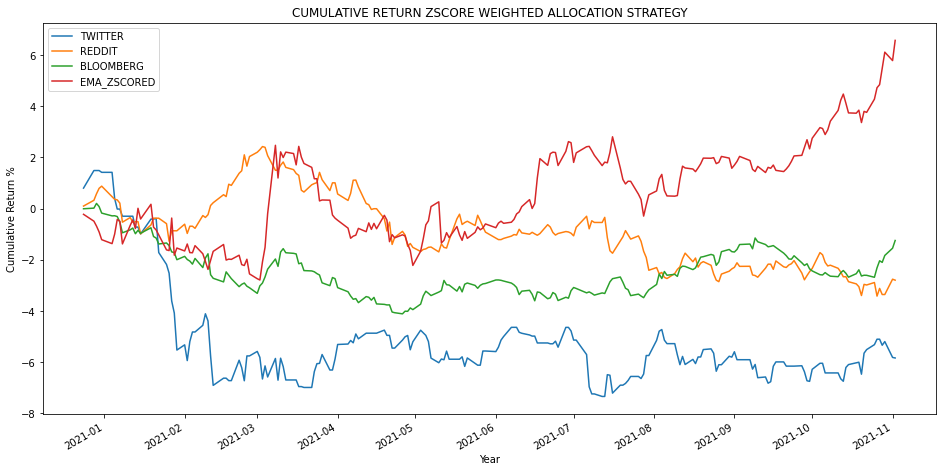

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
TWITTER      -6.73%    6.57%          -5.84%   -8.7%        -1.03   
REDDIT       -3.23%    4.39%           -2.8%  -5.71%        -0.73   
BLOOMBERG    -1.44%     3.1%          -1.25%  -4.31%        -0.45   
EMA_ZSCORED   7.65%    7.23%           6.57%  -4.58%         1.06   

            Sortino Ratio Calmar Ratio  
TWITTER             -1.32        -0.77  
REDDIT              -0.97        -0.57  
BLOOMBERG           -0.64        -0.34  
EMA_ZSCORED          1.62         1.67

In [15]:
singles = zscore_returns[0:4]
singles_corr = pd.concat(singles,axis=1)
singles_corr = pd.concat([singles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(singles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(singles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN ZSCORE WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(singles,axis=1)))


TWITTER_REDDIT_BLOOMBERG  \
TWITTER_REDDIT_BLOOMBERG                              1.000000   
EMA_TWITTER_ZSCORED                                   0.233366   
EMA_REDDIT_ZSCORED                                    0.285844   
EMA_BLOOMBERG_ZSCORED                                 0.452873   
EMA_TWITTER_REDDIT_ZSCORED                            0.335546   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                  0.594157   
EQUAL_RETURNS                                        -0.052630   
XLK_RETURNS                                           0.006939   

                                      EMA_TWITTER_ZSCORED  EMA_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                         0.233366            0.285844   
EMA_TWITTER_ZSCORED                              1.000000            0.952116   
EMA_REDDIT_ZSCORED                               0.952116            1.000000   
EMA_BLOOMBERG_ZSCORED                            0.917820            0.886900   
EMA_TWITTER_REDDIT_ZSCORED                       0.961732            0.988770   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED             0.894736            0.905421   
EQUAL_RETURNS                                   -0.163344           -0.111565   
XLK_RETURNS                                     -0.142126           -0.095065   

                                      EMA_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                           0.452873   
EMA_TWITTER_ZSCORED                                0.917820   
EMA_REDDIT_ZSCORED                                 0.886900   
EMA_BLOOMBERG_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_ZSCORED                         0.883124   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED               0.957460   
EQUAL_RETURNS                                     -0.201199   
XLK_RETURNS                                       -0.162943   

                                      EMA_TWITTER_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                0.335546   
EMA_TWITTER_ZSCORED                                     0.961732   
EMA_REDDIT_ZSCORED                                      0.988770   
EMA_BLOOMBERG_ZSCORED                                   0.883124   
EMA_TWITTER_REDDIT_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                    0.920672   
EQUAL_RETURNS                                          -0.097999   
XLK_RETURNS                                            -0.079668   

                                      EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                          0.594157   
EMA_TWITTER_ZSCORED                                               0.894736   
EMA_REDDIT_ZSCORED                                                0.905421   
EMA_BLOOMBERG_ZSCORED                                             0.957460   
EMA_TWITTER_REDDIT_ZSCORED                                        0.920672   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                              1.000000   
EQUAL_RETURNS                                                    -0.140117   
XLK_RETURNS                                                      -0.101911   

                                      EQUAL_RETURNS  XLK_RETURNS  
TWITTER_REDDIT_BLOOMBERG                  -0.052630     0.006939  
EMA_TWITTER_ZSCORED                       -0.163344    -0.142126  
EMA_REDDIT_ZSCORED                        -0.111565    -0.095065  
EMA_BLOOMBERG_ZSCORED                     -0.201199    -0.162943  
EMA_TWITTER_REDDIT_ZSCORED                -0.097999    -0.079668  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED      -0.140117    -0.101911  
EQUAL_RETURNS                              1.000000     0.884616  
XLK_RETURNS                                0.884616     1.000000

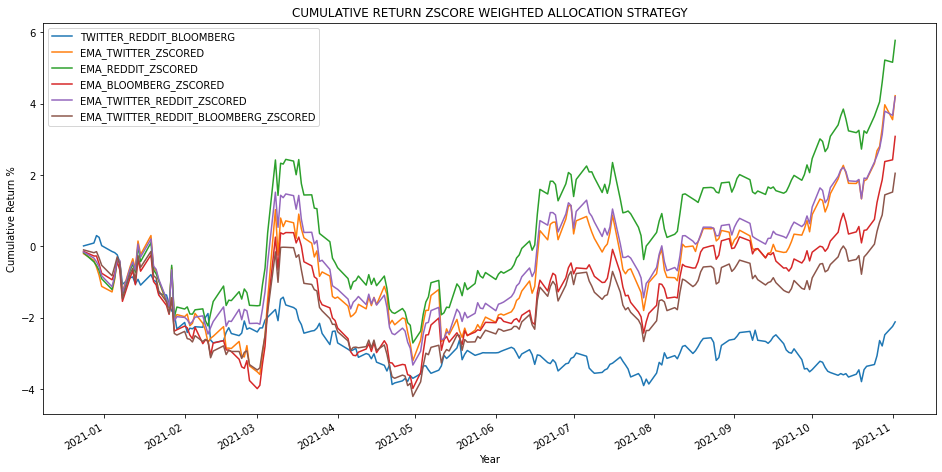

CAGR Ann. Vol Cumulative Ret.     MDD  \
TWITTER_REDDIT_BLOOMBERG              -2.45%     3.1%          -2.12%  -4.19%   
EMA_TWITTER_ZSCORED                     4.9%    6.83%           4.22%  -4.19%   
EMA_REDDIT_ZSCORED                     6.71%    6.12%           5.77%  -5.02%   
EMA_BLOOMBERG_ZSCORED                  3.57%     5.5%           3.08%  -4.35%   
EMA_TWITTER_REDDIT_ZSCORED             4.86%    5.93%           4.19%  -4.77%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED   2.37%     5.0%           2.05%  -4.21%   

                                     Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG                    -0.78         -1.02        -0.58  
EMA_TWITTER_ZSCORED                          0.73           1.1         1.17  
EMA_REDDIT_ZSCORED                           1.09          1.67         1.34  
EMA_BLOOMBERG_ZSCORED                        0.67          1.06         0.82  
EMA_TWITTER_REDDIT_ZSCORED                   0.83          1.25         1.02  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED         0.49          0.76         0.56

In [16]:
doubles = zscore_returns[5:]

doubles_corr = pd.concat(doubles,axis=1)
doubles_corr = pd.concat([doubles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(doubles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(doubles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN ZSCORE WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(doubles,axis=1)))

# RANK WEIGHTED

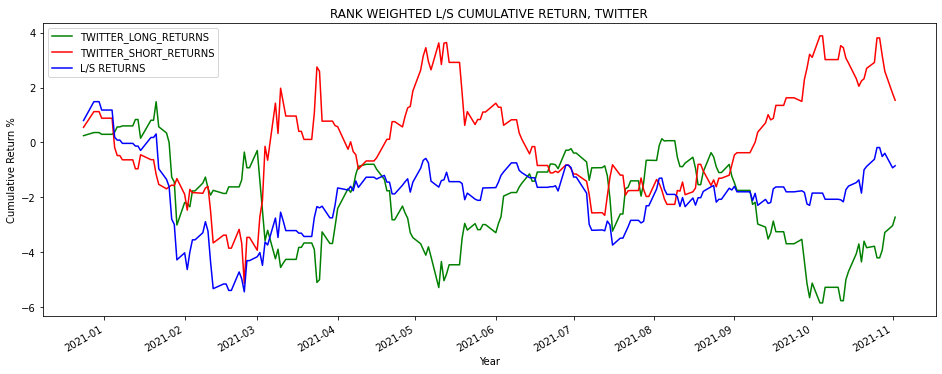

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
TWITTER_LONG_RETURNS   -3.14%    7.54%          -2.72%  -7.22%        -0.39   
TWITTER_SHORT_RETURNS   1.78%    8.29%           1.54%   -6.2%         0.25   
L/S RETURNS            -0.98%    6.09%          -0.85%  -6.83%        -0.13   

                      Sortino Ratio Calmar Ratio  
TWITTER_LONG_RETURNS          -0.52        -0.44  
TWITTER_SHORT_RETURNS          0.39         0.29  
L/S RETURNS                   -0.18        -0.14

Nr of Trading Days, TWITTER :75.93%
Total Nr of stocks trading, TWITTER: 24


TWITTER LONG % 
 
 
 
 
 MSFT 
 54.88 
 
 
 QCOM 
 53.05 
 
 
 AAPL 
 51.22 
 
 
 ADP 
 50.00 
 
 
 LRCX 
 49.39 
 
 
 INTC 
 42.68 
 
 
 CSCO 
 42.68 
 
 
 TER 
 41.46 
 
 
 NVDA 
 40.85 
 
 
 ADI 
 35.98 
 
 
 
 
 
 
 TWITTER SHORT % 
 
 
 
 
 NVDA 
 53.66 
 
 
 INTC 
 53.05 
 
 
 ADBE 
 51.22 
 
 
 PYPL 
 49.39 
 
 
 TER 
 46.95 
 
 
 ADP 
 46.34 
 
 
 AAPL 
 44.51 
 
 
 MSFT 
 42.07 
 
 
 ADI 
 40.24 
 
 
 CRM 
 36.59

Mean Turnover, Long Basket, All days, TWITTER: 0.45
Mean Turnover, Short Basket, All days, TWITTER: 0.44
Mean Turnover, Long Basket, trading days only, TWITTER: 0.17
Mean Turnover, Short Basket, trading days only, TWITTER: 0.16


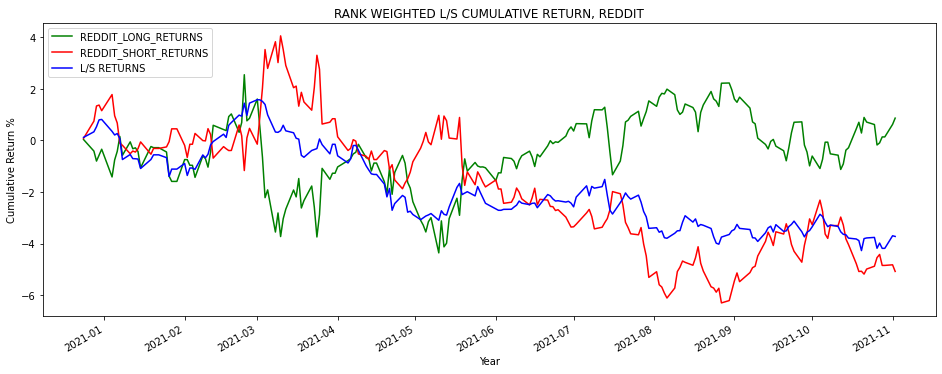

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
REDDIT_LONG_RETURNS     1.0%    9.07%           0.87%  -6.74%         0.16   
REDDIT_SHORT_RETURNS  -5.86%    8.09%          -5.08%  -9.96%        -0.71   
L/S RETURNS            -4.3%     4.3%          -3.72%  -5.76%         -1.0   

                     Sortino Ratio Calmar Ratio  
REDDIT_LONG_RETURNS           0.22         0.15  
REDDIT_SHORT_RETURNS         -0.96        -0.59  
L/S RETURNS                  -1.31        -0.75

Nr of Trading Days, REDDIT :95.83%
Total Nr of stocks trading, REDDIT: 50


REDDIT LONG % 
 
 
 
 
 FTNT 
 77.78 
 
 
 MSI 
 57.97 
 
 
 INTC 
 53.14 
 
 
 CRM 
 52.66 
 
 
 TER 
 51.69 
 
 
 AMD 
 51.69 
 
 
 AVGO 
 51.21 
 
 
 ENPH 
 51.21 
 
 
 TDY 
 50.72 
 
 
 MU 
 50.24 
 
 
 
 
 
 
 REDDIT SHORT % 
 
 
 
 
 ADP 
 62.32 
 
 
 PYPL 
 59.42 
 
 
 AAPL 
 56.52 
 
 
 CSCO 
 56.04 
 
 
 HPE 
 55.07 
 
 
 LRCX 
 53.62 
 
 
 WDC 
 53.62 
 
 
 IBM 
 52.66 
 
 
 ORCL 
 52.17 
 
 
 XLNX 
 50.72

Mean Turnover, Long Basket, All days, REDDIT: 0.22
Mean Turnover, Short Basket, All days, REDDIT: 0.22
Mean Turnover, Long Basket, trading days only, REDDIT: 0.17
Mean Turnover, Short Basket, trading days only, REDDIT: 0.17


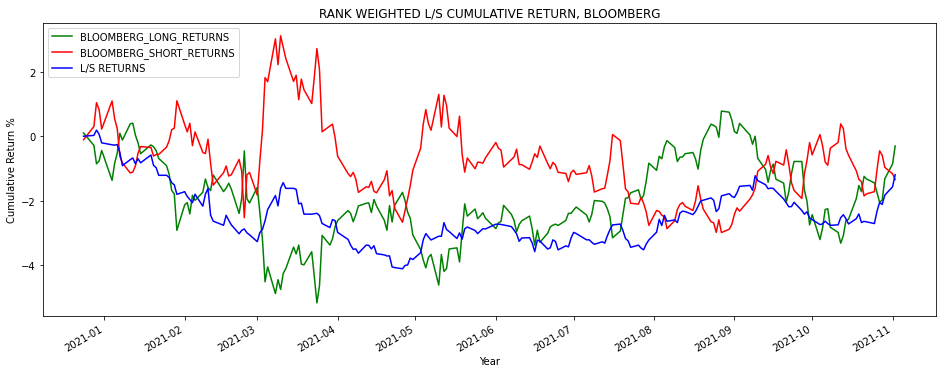

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
BLOOMBERG_LONG_RETURNS   -0.34%     7.3%          -0.29%  -5.56%        -0.01   
BLOOMBERG_SHORT_RETURNS  -1.55%     7.8%          -1.34%  -5.92%        -0.16   
L/S RETURNS              -1.37%    3.17%          -1.19%   -4.3%        -0.42   

                        Sortino Ratio Calmar Ratio  
BLOOMBERG_LONG_RETURNS          -0.01        -0.06  
BLOOMBERG_SHORT_RETURNS         -0.23        -0.26  
L/S RETURNS                      -0.6        -0.32

Nr of Trading Days, BLOOMBERG :100.0%
Total Nr of stocks trading, BLOOMBERG: 75


BLOOMBERG LONG % 
 
 
 
 
 MA 
 58.80 
 
 
 ENPH 
 58.33 
 
 
 FTNT 
 57.87 
 
 
 V 
 55.56 
 
 
 NVDA 
 55.09 
 
 
 NOW 
 54.63 
 
 
 TER 
 53.70 
 
 
 FISV 
 53.24 
 
 
 INTU 
 53.24 
 
 
 INTC 
 53.24 
 
 
 
 
 
 
 BLOOMBERG SHORT % 
 
 
 
 
 ANSS 
 57.41 
 
 
 KEYS 
 56.48 
 
 
 JKHY 
 55.09 
 
 
 BR 
 54.63 
 
 
 PTC 
 54.63 
 
 
 ADSK 
 54.63 
 
 
 NLOK 
 54.17 
 
 
 HPE 
 53.24 
 
 
 IPGP 
 53.24 
 
 
 TEL 
 53.24

Mean Turnover, Long Basket, All days, BLOOMBERG: 0.19
Mean Turnover, Short Basket, All days, BLOOMBERG: 0.2
Mean Turnover, Long Basket, trading days only, BLOOMBERG: 0.19
Mean Turnover, Short Basket, trading days only, BLOOMBERG: 0.2


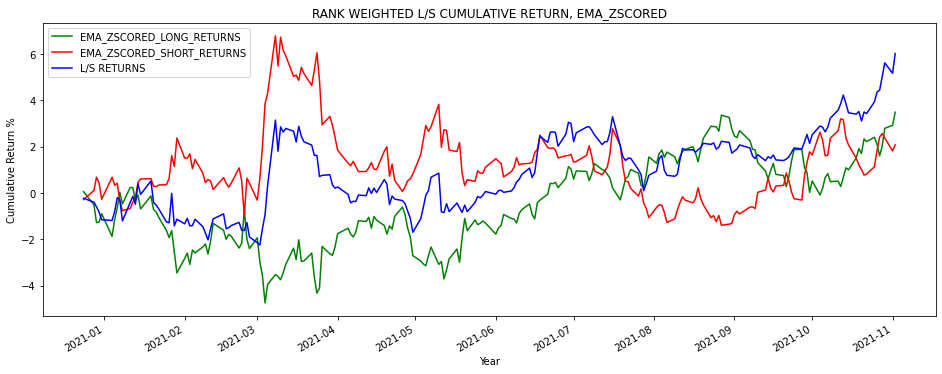

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_ZSCORED_LONG_RETURNS   4.05%    7.71%           3.49%  -4.98%   
EMA_ZSCORED_SHORT_RETURNS  2.41%    8.92%           2.08%  -7.67%   
L/S RETURNS                7.01%    7.37%           6.03%   -4.7%   

                          Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_ZSCORED_LONG_RETURNS          0.55          0.81         0.81  
EMA_ZSCORED_SHORT_RETURNS         0.31          0.46         0.31  
L/S RETURNS                       0.96          1.46         1.49

Nr of Trading Days, EMA_ZSCORED :100.0%
Total Nr of stocks trading, EMA_ZSCORED: 75


EMA_ZSCORED LONG % 
 
 
 
 
 FTNT 
 77.31 
 
 
 INTU 
 66.67 
 
 
 MPWR 
 64.35 
 
 
 IT 
 62.96 
 
 
 KEYS 
 60.65 
 
 
 ZBRA 
 59.26 
 
 
 SNPS 
 59.26 
 
 
 CRM 
 58.80 
 
 
 ANSS 
 58.33 
 
 
 NVDA 
 58.33 
 
 
 
 
 
 
 EMA_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 64.81 
 
 
 WU 
 64.81 
 
 
 GPN 
 62.50 
 
 
 FIS 
 62.50 
 
 
 FISV 
 62.50 
 
 
 GLW 
 61.57 
 
 
 CTSH 
 61.11 
 
 
 FLT 
 61.11 
 
 
 IBM 
 59.72 
 
 
 AKAM 
 59.26

Mean Turnover, Long Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_ZSCORED: 0.19


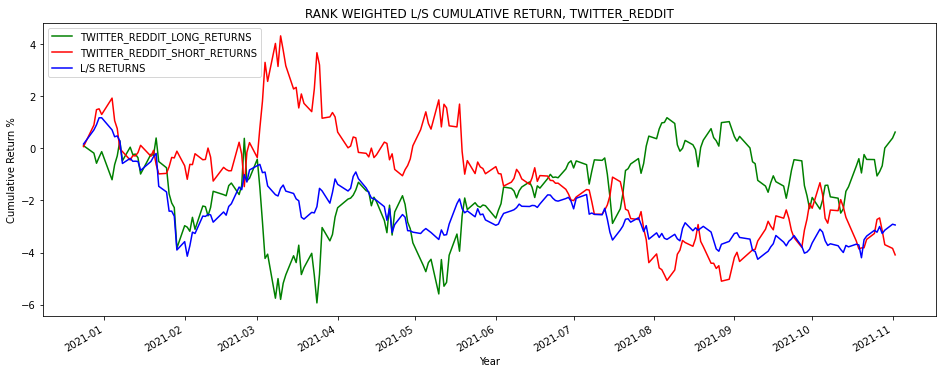

CAGR Ann. Vol Cumulative Ret.     MDD  \
TWITTER_REDDIT_LONG_RETURNS    0.72%    9.47%           0.62%   -6.3%   
TWITTER_REDDIT_SHORT_RETURNS  -4.72%    8.26%          -4.09%  -9.02%   
L/S RETURNS                    -3.4%    5.05%          -2.94%  -5.37%   

                             Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_LONG_RETURNS          0.12          0.17         0.11  
TWITTER_REDDIT_SHORT_RETURNS        -0.54         -0.76        -0.52  
L/S RETURNS                         -0.66         -0.86        -0.63

Nr of Trading Days, TWITTER_REDDIT :100.0%
Total Nr of stocks trading, TWITTER_REDDIT: 52


TWITTER_REDDIT LONG % 
 
 
 
 
 FTNT 
 64.35 
 
 
 CRM 
 53.70 
 
 
 TER 
 53.24 
 
 
 MSFT 
 50.93 
 
 
 AMD 
 49.07 
 
 
 SWKS 
 49.07 
 
 
 BR 
 49.07 
 
 
 MU 
 48.61 
 
 
 NVDA 
 48.61 
 
 
 INTC 
 47.22 
 
 
 
 
 
 
 TWITTER_REDDIT SHORT % 
 
 
 
 
 ORCL 
 57.41 
 
 
 ADP 
 56.94 
 
 
 PYPL 
 55.56 
 
 
 IBM 
 52.31 
 
 
 AAPL 
 51.85 
 
 
 INTC 
 51.85 
 
 
 WDC 
 49.54 
 
 
 QCOM 
 49.54 
 
 
 MSFT 
 49.07 
 
 
 ADBE 
 49.07

Mean Turnover, Long Basket, All days, TWITTER_REDDIT: 0.24
Mean Turnover, Short Basket, All days, TWITTER_REDDIT: 0.21
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT: 0.24
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT: 0.21


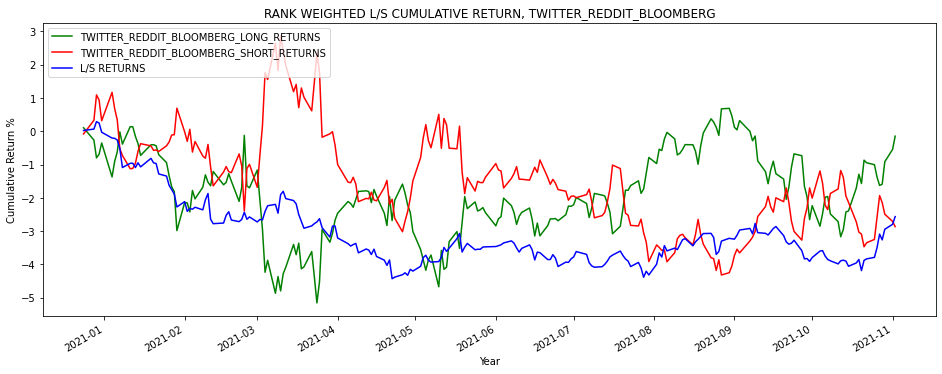

CAGR Ann. Vol Cumulative Ret.  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS   -0.17%    7.55%          -0.15%   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -3.31%    7.69%          -2.87%   
L/S RETURNS                             -2.96%     3.1%          -2.56%   

                                           MDD Sharpe Ratio Sortino Ratio  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS   -5.29%         0.01          0.02   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -6.98%         -0.4         -0.56   
L/S RETURNS                              -4.7%        -0.96         -1.22   

                                       Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS         -0.03  
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS        -0.47  
L/S RETURNS                                   -0.63

Nr of Trading Days, TWITTER_REDDIT_BLOOMBERG :100.0%
Total Nr of stocks trading, TWITTER_REDDIT_BLOOMBERG: 75


TWITTER_REDDIT_BLOOMBERG LONG % 
 
 
 
 
 FTNT 
 62.96 
 
 
 TER 
 58.33 
 
 
 AVGO 
 57.87 
 
 
 QCOM 
 57.87 
 
 
 MA 
 57.41 
 
 
 MSFT 
 56.02 
 
 
 SWKS 
 55.56 
 
 
 NXPI 
 55.56 
 
 
 V 
 55.09 
 
 
 NOW 
 55.09 
 
 
 
 
 
 
 TWITTER_REDDIT_BLOOMBERG SHORT % 
 
 
 
 
 PAYX 
 58.80 
 
 
 TRMB 
 58.80 
 
 
 KEYS 
 58.33 
 
 
 ADP 
 57.41 
 
 
 ADSK 
 56.94 
 
 
 ANSS 
 56.94 
 
 
 NLOK 
 56.48 
 
 
 BR 
 56.02 
 
 
 WDC 
 55.56 
 
 
 PTC 
 55.09

Mean Turnover, Long Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Short Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.21


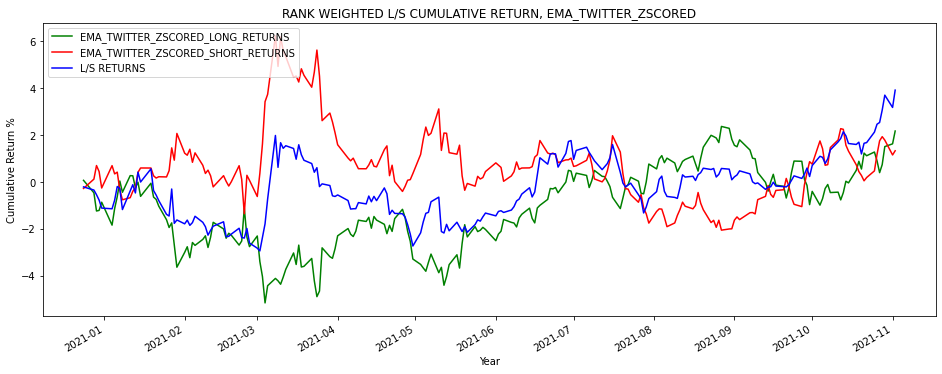

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_TWITTER_ZSCORED_LONG_RETURNS   2.51%     7.7%           2.17%  -5.41%   
EMA_TWITTER_ZSCORED_SHORT_RETURNS  1.54%    8.82%           1.33%   -7.8%   
L/S RETURNS                        4.54%    7.07%           3.91%  -4.62%   

                                  Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_TWITTER_ZSCORED_LONG_RETURNS          0.36          0.52         0.46  
EMA_TWITTER_ZSCORED_SHORT_RETURNS         0.22          0.32          0.2  
L/S RETURNS                               0.66          0.99         0.98

Nr of Trading Days, EMA_TWITTER_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_ZSCORED: 75


EMA_TWITTER_ZSCORED LONG % 
 
 
 
 
 FTNT 
 76.85 
 
 
 MPWR 
 65.28 
 
 
 INTU 
 65.28 
 
 
 IT 
 62.50 
 
 
 KEYS 
 61.57 
 
 
 SNPS 
 60.65 
 
 
 CDNS 
 59.26 
 
 
 ANSS 
 58.80 
 
 
 MSI 
 58.33 
 
 
 CDW 
 57.87 
 
 
 
 
 
 
 EMA_TWITTER_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 64.35 
 
 
 WU 
 62.50 
 
 
 GPN 
 62.04 
 
 
 FISV 
 62.04 
 
 
 FIS 
 61.57 
 
 
 QCOM 
 60.65 
 
 
 FLT 
 60.19 
 
 
 GLW 
 59.72 
 
 
 CTSH 
 59.72 
 
 
 INTC 
 58.33

Mean Turnover, Long Basket, All days, EMA_TWITTER_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_TWITTER_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_ZSCORED: 0.2


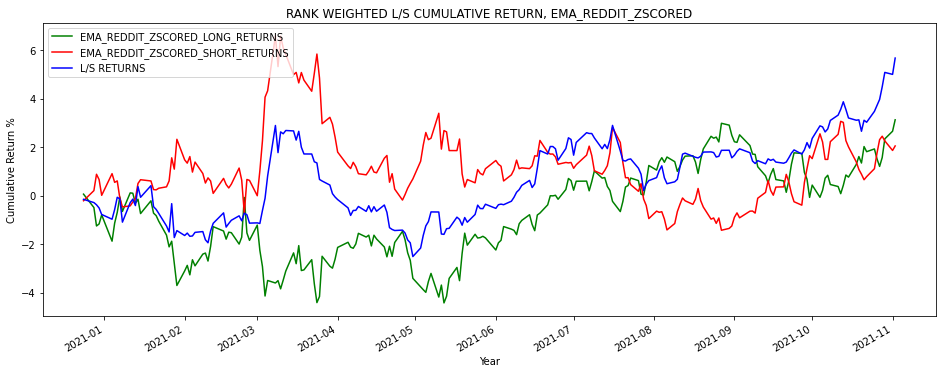

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_REDDIT_ZSCORED_LONG_RETURNS   3.62%    7.84%           3.12%  -4.53%   
EMA_REDDIT_ZSCORED_SHORT_RETURNS  2.37%    8.52%           2.05%  -7.52%   
L/S RETURNS                       6.59%    6.12%           5.67%  -5.25%   

                                 Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_REDDIT_ZSCORED_LONG_RETURNS          0.49          0.72          0.8  
EMA_REDDIT_ZSCORED_SHORT_RETURNS         0.32          0.47         0.32  
L/S RETURNS                              1.07          1.63         1.25

Nr of Trading Days, EMA_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_REDDIT_ZSCORED: 75


EMA_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 74.07 
 
 
 IT 
 65.28 
 
 
 MPWR 
 64.81 
 
 
 NVDA 
 60.19 
 
 
 ANSS 
 60.19 
 
 
 INTU 
 59.26 
 
 
 ADBE 
 58.33 
 
 
 SNPS 
 57.87 
 
 
 CDNS 
 57.41 
 
 
 CDW 
 56.94 
 
 
 
 
 
 
 EMA_REDDIT_ZSCORED SHORT % 
 
 
 
 
 FISV 
 67.59 
 
 
 FLT 
 64.35 
 
 
 CSCO 
 63.89 
 
 
 CTXS 
 63.43 
 
 
 FIS 
 62.04 
 
 
 GPN 
 61.57 
 
 
 WDC 
 61.11 
 
 
 WU 
 60.65 
 
 
 CTSH 
 60.19 
 
 
 ADP 
 60.19

Mean Turnover, Long Basket, All days, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_REDDIT_ZSCORED: 0.19


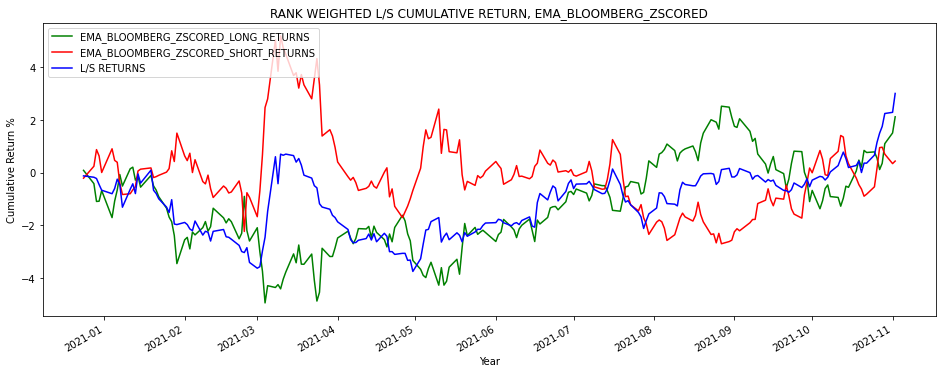

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS   2.46%    7.45%           2.12%  -5.14%   
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS  0.51%    8.66%           0.44%   -7.5%   
L/S RETURNS                          3.49%    5.57%            3.0%  -4.42%   

                                    Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS          0.36          0.53         0.48  
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS          0.1          0.15         0.07  
L/S RETURNS                                 0.64          1.03         0.79

Nr of Trading Days, EMA_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_BLOOMBERG_ZSCORED: 75


EMA_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 70.37 
 
 
 IT 
 61.11 
 
 
 MPWR 
 60.19 
 
 
 INTU 
 59.26 
 
 
 XLNX 
 56.94 
 
 
 CDW 
 56.94 
 
 
 CDNS 
 56.02 
 
 
 CDAY 
 55.56 
 
 
 NVDA 
 55.09 
 
 
 NOW 
 55.09 
 
 
 
 
 
 
 EMA_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 60.19 
 
 
 CTSH 
 58.80 
 
 
 GPN 
 58.33 
 
 
 INTC 
 56.02 
 
 
 AKAM 
 55.56 
 
 
 FLT 
 55.56 
 
 
 MA 
 55.09 
 
 
 HPQ 
 55.09 
 
 
 IBM 
 54.63 
 
 
 CSCO 
 54.17

Mean Turnover, Long Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2


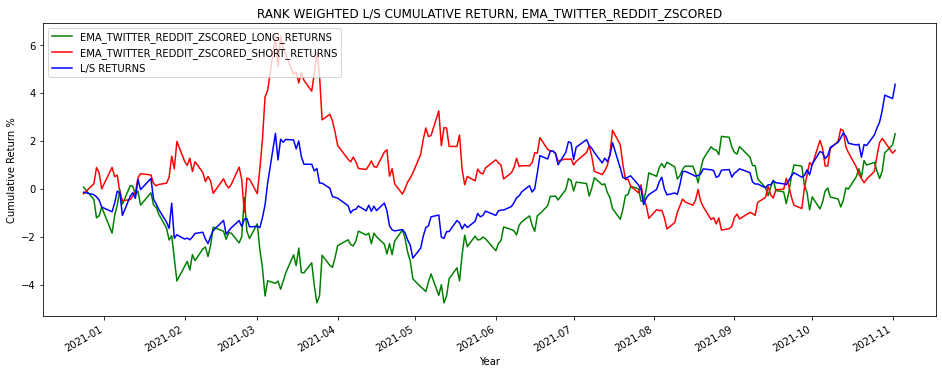

CAGR Ann. Vol Cumulative Ret.  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS   2.66%    7.84%           2.29%   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  1.85%    8.46%            1.6%   
L/S RETURNS                               5.06%    6.07%           4.35%   

                                             MDD Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS   -4.88%         0.37          0.54   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  -7.62%         0.26          0.38   
L/S RETURNS                               -5.08%         0.84          1.26   

                                         Calmar Ratio  
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS          0.54  
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS         0.24  
L/S RETURNS                                      0.99

Nr of Trading Days, EMA_TWITTER_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_ZSCORED: 75


EMA_TWITTER_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 74.07 
 
 
 MPWR 
 65.28 
 
 
 IT 
 64.35 
 
 
 INTU 
 60.65 
 
 
 ANSS 
 60.19 
 
 
 SNPS 
 59.26 
 
 
 NVDA 
 59.26 
 
 
 CDNS 
 58.80 
 
 
 HPQ 
 58.80 
 
 
 KEYS 
 58.33 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_ZSCORED SHORT % 
 
 
 
 
 FISV 
 67.13 
 
 
 FLT 
 65.28 
 
 
 ADP 
 63.43 
 
 
 CTXS 
 63.43 
 
 
 FIS 
 62.04 
 
 
 GPN 
 61.57 
 
 
 WU 
 60.65 
 
 
 WDC 
 60.65 
 
 
 CTSH 
 59.72 
 
 
 CSCO 
 59.72

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.19


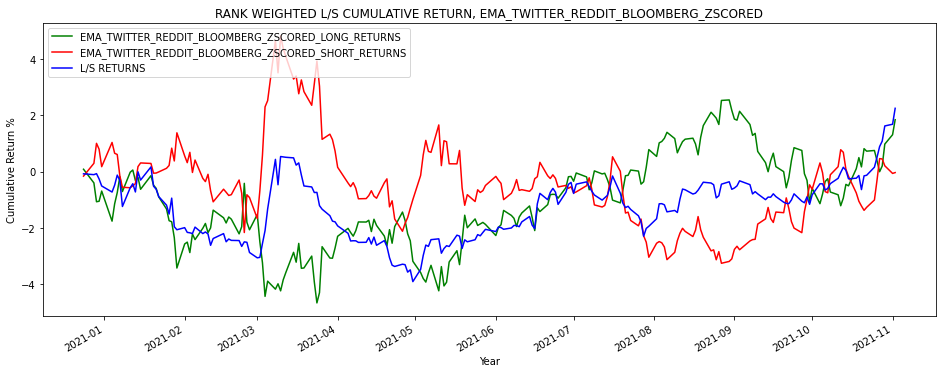

CAGR Ann. Vol  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS    2.13%    7.55%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS  -0.04%    8.35%   
L/S RETURNS                                           2.6%    5.09%   

                                                   Cumulative Ret.     MDD  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS            1.84%  -4.74%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS          -0.04%   -7.7%   
L/S RETURNS                                                  2.24%  -4.42%   

                                                   Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS          0.32          0.46   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS         0.04          0.05   
L/S RETURNS                                                0.53          0.82   

                                                   Calmar Ratio  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS          0.45  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS        -0.01  
L/S RETURNS                                                0.59

Nr of Trading Days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 75


EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 73.15 
 
 
 IT 
 62.96 
 
 
 MPWR 
 61.11 
 
 
 AVGO 
 57.41 
 
 
 NVDA 
 56.94 
 
 
 TER 
 56.48 
 
 
 CDW 
 56.48 
 
 
 MSFT 
 55.56 
 
 
 CDAY 
 55.56 
 
 
 CDNS 
 55.09 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 ADP 
 62.04 
 
 
 CTSH 
 61.11 
 
 
 CTXS 
 60.65 
 
 
 WDC 
 60.19 
 
 
 FLT 
 58.80 
 
 
 FISV 
 58.33 
 
 
 GPN 
 58.33 
 
 
 IBM 
 56.94 
 
 
 WU 
 55.56 
 
 
 FFIV 
 55.09

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2


In [17]:
zscore_returns = []

for i in signal_df_list:
    
    STRATEGY_RETURNS, LS_RETURNS, DIAGNOSTICS_DF = backtest_rank(
                                                                     signal_df              = i,
                                                                     returns_df             = returns_df ,
                                                                     upper_q                = upper_q,
                                                                     lower_q                = lower_q,
                                                                     min_stocks_each_basket = min_stocks_each_basket,
                                                                    
                                                        )
    
    zscore_returns.append(STRATEGY_RETURNS)

    LS_RETURNS['L/S RETURNS'] = LS_RETURNS.sum(axis=1)

    fig, ax = plt.subplots(figsize=(16,6))

    cum = cum_returns(LS_RETURNS)*100

    cum.plot(ax=ax,color = ['green','red','blue'])                               

    ax.legend(cum.columns,loc=2)
    plt.ylabel('Cumulative Return %')
    plt.xlabel('Year')
    ax.set_title('RANK WEIGHTED L/S CUMULATIVE RETURN, '+str(STRATEGY_RETURNS.columns[0]))
    plt.show()
    display(backtest_metrics(LS_RETURNS))
    nr_of_trading_days(STRATEGY_RETURNS)
    total_number_of_trading_stocks(DIAGNOSTICS_DF)
    stats_long_short(DIAGNOSTICS_DF)
    top_10_stocks_traded(DIAGNOSTICS_DF)
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='NO')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='NO')

TWITTER    REDDIT  BLOOMBERG  EMA_ZSCORED  EQUAL_RETURNS  \
TWITTER        1.000000 -0.013246   0.271793     0.071491      -0.104730   
REDDIT        -0.013246  1.000000  -0.079266    -0.121072       0.198987   
BLOOMBERG      0.271793 -0.079266   1.000000     0.265244      -0.167364   
EMA_ZSCORED    0.071491 -0.121072   0.265244     1.000000      -0.191230   
EQUAL_RETURNS -0.104730  0.198987  -0.167364    -0.191230       1.000000   
XLK_RETURNS   -0.038732  0.165634  -0.093979    -0.174889       0.884616   

               XLK_RETURNS  
TWITTER          -0.038732  
REDDIT            0.165634  
BLOOMBERG        -0.093979  
EMA_ZSCORED      -0.174889  
EQUAL_RETURNS     0.884616  
XLK_RETURNS       1.000000

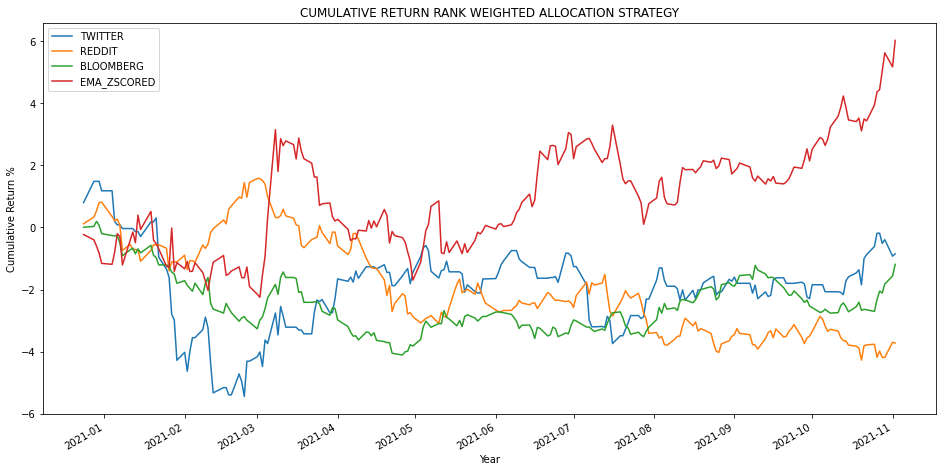

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
TWITTER      -0.98%    6.09%          -0.85%  -6.83%        -0.13   
REDDIT        -4.3%     4.3%          -3.72%  -5.76%         -1.0   
BLOOMBERG    -1.37%    3.17%          -1.19%   -4.3%        -0.42   
EMA_ZSCORED   7.01%    7.37%           6.03%   -4.7%         0.96   

            Sortino Ratio Calmar Ratio  
TWITTER             -0.18        -0.14  
REDDIT              -1.31        -0.75  
BLOOMBERG            -0.6        -0.32  
EMA_ZSCORED          1.46         1.49

In [18]:
singles = zscore_returns[0:4]

singles_corr = pd.concat(singles,axis=1)
singles_corr = pd.concat([singles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(singles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(singles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN RANK WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(singles,axis=1)))

TWITTER_REDDIT_BLOOMBERG  \
TWITTER_REDDIT_BLOOMBERG                              1.000000   
EMA_TWITTER_ZSCORED                                   0.196660   
EMA_REDDIT_ZSCORED                                    0.245262   
EMA_BLOOMBERG_ZSCORED                                 0.434824   
EMA_TWITTER_REDDIT_ZSCORED                            0.286858   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                  0.558669   
EQUAL_RETURNS                                        -0.063744   
XLK_RETURNS                                           0.010944   

                                      EMA_TWITTER_ZSCORED  EMA_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                         0.196660            0.245262   
EMA_TWITTER_ZSCORED                              1.000000            0.951055   
EMA_REDDIT_ZSCORED                               0.951055            1.000000   
EMA_BLOOMBERG_ZSCORED                            0.915325            0.881561   
EMA_TWITTER_REDDIT_ZSCORED                       0.963057            0.990505   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED             0.898155            0.907292   
EQUAL_RETURNS                                   -0.180106           -0.124246   
XLK_RETURNS                                     -0.161943           -0.110927   

                                      EMA_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                           0.434824   
EMA_TWITTER_ZSCORED                                0.915325   
EMA_REDDIT_ZSCORED                                 0.881561   
EMA_BLOOMBERG_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_ZSCORED                         0.884479   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED               0.962690   
EQUAL_RETURNS                                     -0.201614   
XLK_RETURNS                                       -0.167320   

                                      EMA_TWITTER_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                0.286858   
EMA_TWITTER_ZSCORED                                     0.963057   
EMA_REDDIT_ZSCORED                                      0.990505   
EMA_BLOOMBERG_ZSCORED                                   0.884479   
EMA_TWITTER_REDDIT_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                    0.922848   
EQUAL_RETURNS                                          -0.115879   
XLK_RETURNS                                            -0.100393   

                                      EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                          0.558669   
EMA_TWITTER_ZSCORED                                               0.898155   
EMA_REDDIT_ZSCORED                                                0.907292   
EMA_BLOOMBERG_ZSCORED                                             0.962690   
EMA_TWITTER_REDDIT_ZSCORED                                        0.922848   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                              1.000000   
EQUAL_RETURNS                                                    -0.144513   
XLK_RETURNS                                                      -0.110203   

                                      EQUAL_RETURNS  XLK_RETURNS  
TWITTER_REDDIT_BLOOMBERG                  -0.063744     0.010944  
EMA_TWITTER_ZSCORED                       -0.180106    -0.161943  
EMA_REDDIT_ZSCORED                        -0.124246    -0.110927  
EMA_BLOOMBERG_ZSCORED                     -0.201614    -0.167320  
EMA_TWITTER_REDDIT_ZSCORED                -0.115879    -0.100393  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED      -0.144513    -0.110203  
EQUAL_RETURNS                              1.000000     0.884616  
XLK_RETURNS                                0.884616     1.000000

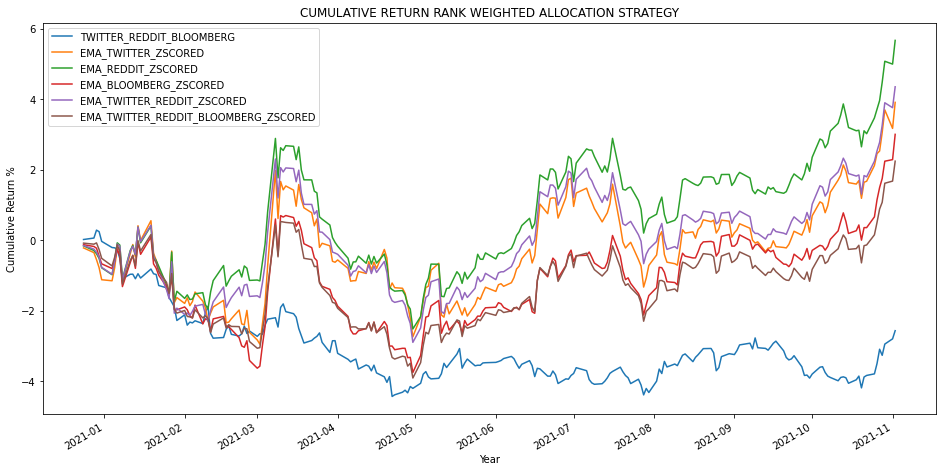

CAGR Ann. Vol Cumulative Ret.     MDD  \
TWITTER_REDDIT_BLOOMBERG              -2.96%     3.1%          -2.56%   -4.7%   
EMA_TWITTER_ZSCORED                    4.54%    7.07%           3.91%  -4.62%   
EMA_REDDIT_ZSCORED                     6.59%    6.12%           5.67%  -5.25%   
EMA_BLOOMBERG_ZSCORED                  3.49%    5.57%            3.0%  -4.42%   
EMA_TWITTER_REDDIT_ZSCORED             5.06%    6.07%           4.35%  -5.08%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED    2.6%    5.09%           2.24%  -4.42%   

                                     Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG                    -0.96         -1.22        -0.63  
EMA_TWITTER_ZSCORED                          0.66          0.99         0.98  
EMA_REDDIT_ZSCORED                           1.07          1.63         1.25  
EMA_BLOOMBERG_ZSCORED                        0.64          1.03         0.79  
EMA_TWITTER_REDDIT_ZSCORED                   0.84          1.26         0.99  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED         0.53          0.82         0.59

In [19]:
doubles = zscore_returns[5:]

doubles_corr = pd.concat(doubles,axis=1)
doubles_corr = pd.concat([doubles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(doubles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(doubles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN RANK WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(doubles,axis=1)))

# OPEN TO OPEN

In [20]:
upper_q = 0.5
lower_q = 0.5
min_stocks_each_basket = 1
extra_weight = 0.2 # in min-max weighting due to min value is removed from the lowest value, 
                   #making the smallest value having zero weight which is a problem
                   # when the number of stocks in each basket is small.
        
returns_df = OPEN_TO_OPEN_STOCK_RETURNS.copy()

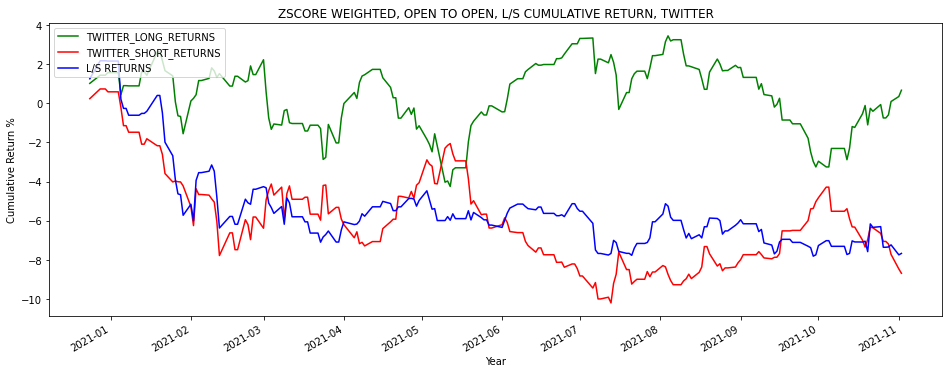

CAGR Ann. Vol Cumulative Ret.      MDD Sharpe Ratio  \
TWITTER_LONG_RETURNS    0.77%    8.94%           0.67%    -6.7%         0.13   
TWITTER_SHORT_RETURNS  -9.98%    9.16%          -8.68%  -10.85%         -1.1   
L/S RETURNS            -8.82%    7.88%          -7.67%   -9.77%        -1.13   

                      Sortino Ratio Calmar Ratio  
TWITTER_LONG_RETURNS           0.18         0.12  
TWITTER_SHORT_RETURNS         -1.56        -0.92  
L/S RETURNS                   -1.51         -0.9

Nr of Trading Days, TWITTER :75.93%
Total Nr of stocks trading, TWITTER: 24


TWITTER LONG % 
 
 
 
 
 MSFT 
 54.88 
 
 
 QCOM 
 53.05 
 
 
 AAPL 
 51.22 
 
 
 ADP 
 50.00 
 
 
 LRCX 
 49.39 
 
 
 INTC 
 42.68 
 
 
 CSCO 
 42.68 
 
 
 TER 
 41.46 
 
 
 NVDA 
 40.85 
 
 
 ADI 
 35.98 
 
 
 
 
 
 
 TWITTER SHORT % 
 
 
 
 
 NVDA 
 53.66 
 
 
 INTC 
 53.05 
 
 
 ADBE 
 51.22 
 
 
 PYPL 
 49.39 
 
 
 TER 
 46.95 
 
 
 ADP 
 46.34 
 
 
 AAPL 
 44.51 
 
 
 MSFT 
 42.07 
 
 
 ADI 
 40.24 
 
 
 CRM 
 36.59

Mean Turnover, Long Basket, All days, TWITTER: 0.45
Mean Turnover, Short Basket, All days, TWITTER: 0.44
Mean Turnover, Long Basket, trading days only, TWITTER: 0.17
Mean Turnover, Short Basket, trading days only, TWITTER: 0.16


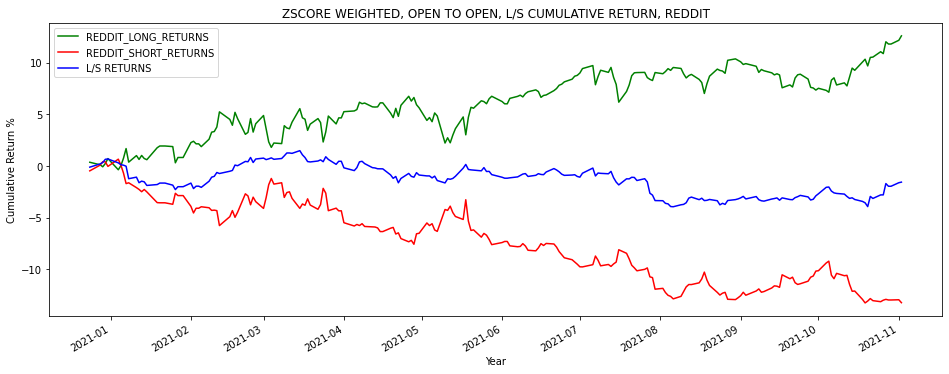

CAGR Ann. Vol Cumulative Ret.      MDD Sharpe Ratio  \
REDDIT_LONG_RETURNS     14.7%   10.37%          12.58%   -4.24%         1.38   
REDDIT_SHORT_RETURNS  -15.14%    9.52%         -13.23%  -13.81%        -1.68   
L/S RETURNS            -1.81%     4.9%          -1.57%   -5.35%        -0.35   

                     Sortino Ratio Calmar Ratio  
REDDIT_LONG_RETURNS           1.97         3.47  
REDDIT_SHORT_RETURNS         -2.28         -1.1  
L/S RETURNS                  -0.48        -0.34

Nr of Trading Days, REDDIT :95.83%
Total Nr of stocks trading, REDDIT: 50


REDDIT LONG % 
 
 
 
 
 FTNT 
 77.78 
 
 
 MSI 
 57.97 
 
 
 INTC 
 53.14 
 
 
 CRM 
 52.66 
 
 
 TER 
 51.69 
 
 
 AMD 
 51.69 
 
 
 AVGO 
 51.21 
 
 
 ENPH 
 51.21 
 
 
 TDY 
 50.72 
 
 
 MU 
 50.24 
 
 
 
 
 
 
 REDDIT SHORT % 
 
 
 
 
 ADP 
 62.32 
 
 
 PYPL 
 59.42 
 
 
 AAPL 
 56.52 
 
 
 CSCO 
 56.04 
 
 
 HPE 
 55.07 
 
 
 LRCX 
 53.62 
 
 
 WDC 
 53.62 
 
 
 IBM 
 52.66 
 
 
 ORCL 
 52.17 
 
 
 XLNX 
 50.72

Mean Turnover, Long Basket, All days, REDDIT: 0.22
Mean Turnover, Short Basket, All days, REDDIT: 0.22
Mean Turnover, Long Basket, trading days only, REDDIT: 0.17
Mean Turnover, Short Basket, trading days only, REDDIT: 0.17


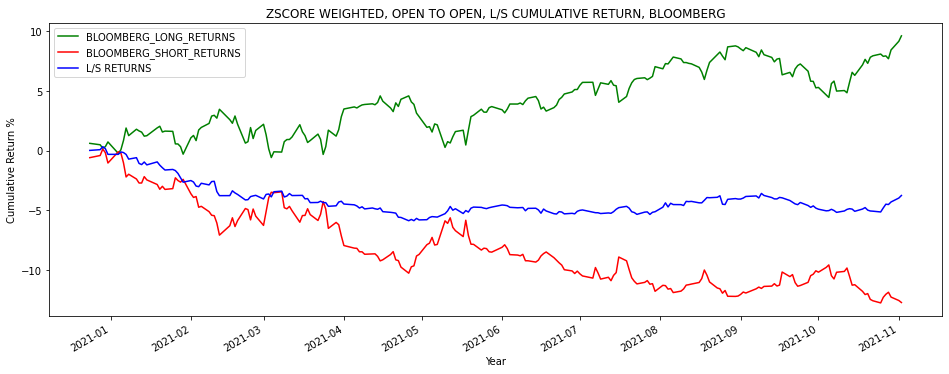

CAGR Ann. Vol Cumulative Ret.      MDD  \
BLOOMBERG_LONG_RETURNS    11.21%    8.54%           9.61%   -4.13%   
BLOOMBERG_SHORT_RETURNS  -14.58%     8.8%         -12.73%  -12.87%   
L/S RETURNS               -4.34%    3.41%          -3.76%   -6.19%   

                        Sharpe Ratio Sortino Ratio Calmar Ratio  
BLOOMBERG_LONG_RETURNS          1.29          1.86         2.72  
BLOOMBERG_SHORT_RETURNS        -1.75         -2.36        -1.13  
L/S RETURNS                    -1.28         -1.66         -0.7

Nr of Trading Days, BLOOMBERG :100.0%
Total Nr of stocks trading, BLOOMBERG: 75


BLOOMBERG LONG % 
 
 
 
 
 MA 
 58.80 
 
 
 ENPH 
 58.33 
 
 
 FTNT 
 57.87 
 
 
 V 
 55.56 
 
 
 NVDA 
 55.09 
 
 
 NOW 
 54.63 
 
 
 TER 
 53.70 
 
 
 FISV 
 53.24 
 
 
 INTU 
 53.24 
 
 
 INTC 
 53.24 
 
 
 
 
 
 
 BLOOMBERG SHORT % 
 
 
 
 
 ANSS 
 57.41 
 
 
 KEYS 
 56.48 
 
 
 JKHY 
 55.09 
 
 
 BR 
 54.63 
 
 
 PTC 
 54.63 
 
 
 ADSK 
 54.63 
 
 
 NLOK 
 54.17 
 
 
 HPE 
 53.24 
 
 
 IPGP 
 53.24 
 
 
 TEL 
 53.24

Mean Turnover, Long Basket, All days, BLOOMBERG: 0.19
Mean Turnover, Short Basket, All days, BLOOMBERG: 0.2
Mean Turnover, Long Basket, trading days only, BLOOMBERG: 0.19
Mean Turnover, Short Basket, trading days only, BLOOMBERG: 0.2


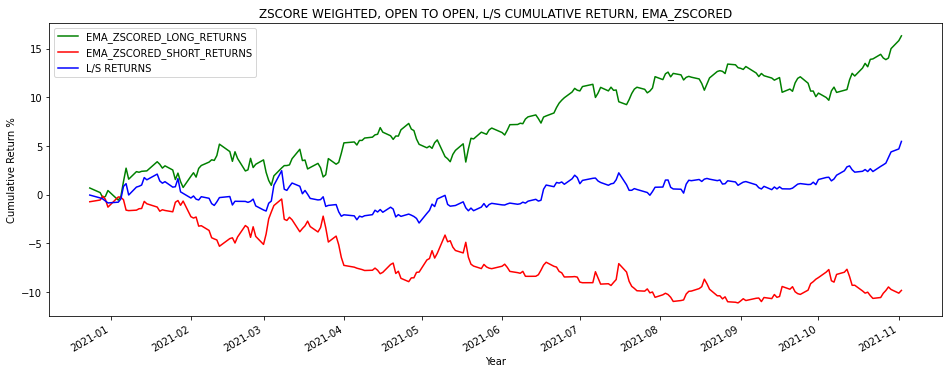

CAGR Ann. Vol Cumulative Ret.      MDD  \
EMA_ZSCORED_LONG_RETURNS    19.11%    9.16%          16.31%   -4.02%   
EMA_ZSCORED_SHORT_RETURNS  -11.29%     9.8%          -9.83%  -11.12%   
L/S RETURNS                  6.36%    7.08%           5.47%   -5.24%   

                          Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_ZSCORED_LONG_RETURNS          1.96          2.93         4.76  
EMA_ZSCORED_SHORT_RETURNS        -1.17         -1.58        -1.02  
L/S RETURNS                       0.91          1.32         1.21

Nr of Trading Days, EMA_ZSCORED :100.0%
Total Nr of stocks trading, EMA_ZSCORED: 75


EMA_ZSCORED LONG % 
 
 
 
 
 FTNT 
 77.31 
 
 
 INTU 
 66.67 
 
 
 MPWR 
 64.35 
 
 
 IT 
 62.96 
 
 
 KEYS 
 60.65 
 
 
 ZBRA 
 59.26 
 
 
 SNPS 
 59.26 
 
 
 CRM 
 58.80 
 
 
 ANSS 
 58.33 
 
 
 NVDA 
 58.33 
 
 
 
 
 
 
 EMA_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 64.81 
 
 
 WU 
 64.81 
 
 
 GPN 
 62.50 
 
 
 FIS 
 62.50 
 
 
 FISV 
 62.50 
 
 
 GLW 
 61.57 
 
 
 CTSH 
 61.11 
 
 
 FLT 
 61.11 
 
 
 IBM 
 59.72 
 
 
 AKAM 
 59.26

Mean Turnover, Long Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_ZSCORED: 0.19


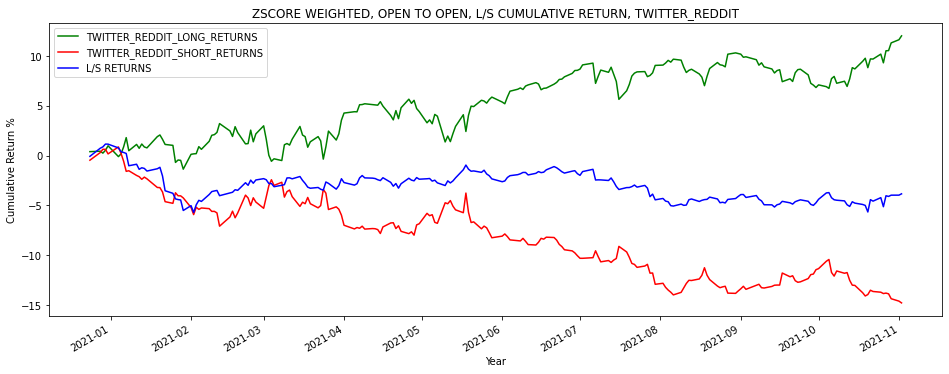

CAGR Ann. Vol Cumulative Ret.      MDD  \
TWITTER_REDDIT_LONG_RETURNS    14.03%    10.7%          12.01%   -4.06%   
TWITTER_REDDIT_SHORT_RETURNS  -16.92%     9.7%          -14.8%  -15.52%   
L/S RETURNS                    -4.44%    6.07%          -3.85%   -6.78%   

                             Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_LONG_RETURNS          1.28          1.81         3.46  
TWITTER_REDDIT_SHORT_RETURNS        -1.86         -2.55        -1.09  
L/S RETURNS                         -0.72         -0.97        -0.65

Nr of Trading Days, TWITTER_REDDIT :100.0%
Total Nr of stocks trading, TWITTER_REDDIT: 52


TWITTER_REDDIT LONG % 
 
 
 
 
 FTNT 
 64.35 
 
 
 CRM 
 53.70 
 
 
 TER 
 53.24 
 
 
 MSFT 
 50.93 
 
 
 AMD 
 49.07 
 
 
 SWKS 
 49.07 
 
 
 BR 
 49.07 
 
 
 MU 
 48.61 
 
 
 NVDA 
 48.61 
 
 
 INTC 
 47.22 
 
 
 
 
 
 
 TWITTER_REDDIT SHORT % 
 
 
 
 
 ORCL 
 57.41 
 
 
 ADP 
 56.94 
 
 
 PYPL 
 55.56 
 
 
 IBM 
 52.31 
 
 
 AAPL 
 51.85 
 
 
 INTC 
 51.85 
 
 
 WDC 
 49.54 
 
 
 QCOM 
 49.54 
 
 
 MSFT 
 49.07 
 
 
 ADBE 
 49.07

Mean Turnover, Long Basket, All days, TWITTER_REDDIT: 0.24
Mean Turnover, Short Basket, All days, TWITTER_REDDIT: 0.21
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT: 0.24
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT: 0.21


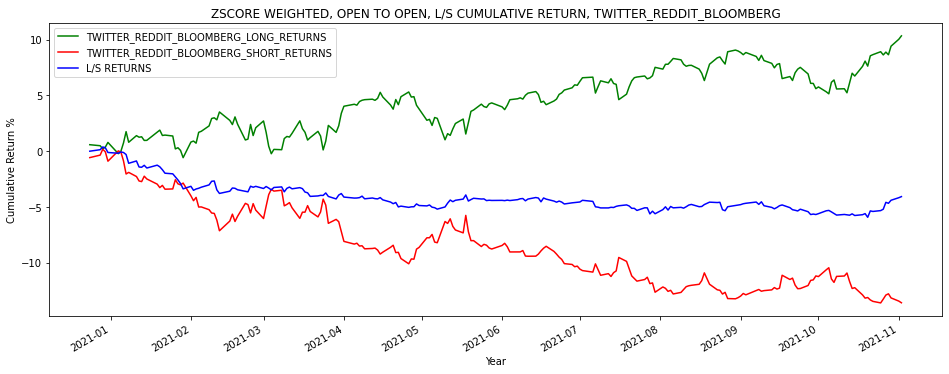

CAGR Ann. Vol Cumulative Ret.  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS    12.05%    8.82%          10.33%   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -15.56%    8.78%          -13.6%   
L/S RETURNS                              -4.71%    3.58%          -4.08%   

                                            MDD Sharpe Ratio Sortino Ratio  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS    -4.07%         1.33          1.92   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -13.75%        -1.88         -2.52   
L/S RETURNS                              -6.28%        -1.33         -1.68   

                                       Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS          2.96  
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS        -1.13  
L/S RETURNS                                   -0.75

Nr of Trading Days, TWITTER_REDDIT_BLOOMBERG :100.0%
Total Nr of stocks trading, TWITTER_REDDIT_BLOOMBERG: 75


TWITTER_REDDIT_BLOOMBERG LONG % 
 
 
 
 
 FTNT 
 62.96 
 
 
 TER 
 58.33 
 
 
 AVGO 
 57.87 
 
 
 QCOM 
 57.87 
 
 
 MA 
 57.41 
 
 
 MSFT 
 56.02 
 
 
 SWKS 
 55.56 
 
 
 NXPI 
 55.56 
 
 
 V 
 55.09 
 
 
 NOW 
 55.09 
 
 
 
 
 
 
 TWITTER_REDDIT_BLOOMBERG SHORT % 
 
 
 
 
 PAYX 
 58.80 
 
 
 TRMB 
 58.80 
 
 
 KEYS 
 58.33 
 
 
 ADP 
 57.41 
 
 
 ADSK 
 56.94 
 
 
 ANSS 
 56.94 
 
 
 NLOK 
 56.48 
 
 
 BR 
 56.02 
 
 
 WDC 
 55.56 
 
 
 PTC 
 55.09

Mean Turnover, Long Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Short Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.21


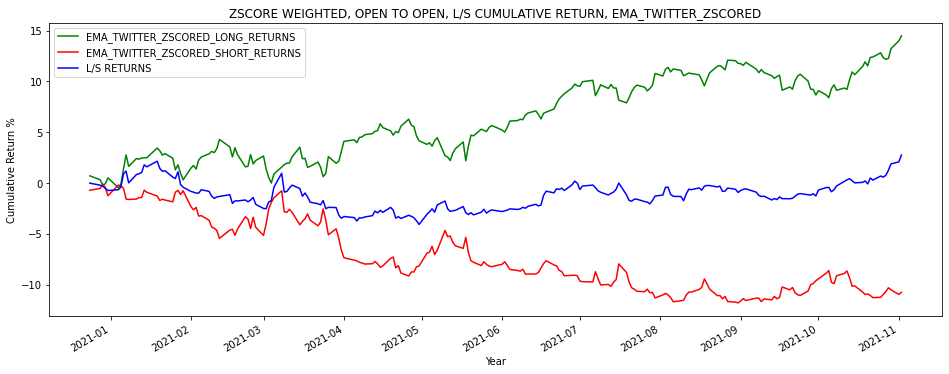

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_TWITTER_ZSCORED_LONG_RETURNS    16.94%    9.16%          14.47%  -4.11%   
EMA_TWITTER_ZSCORED_SHORT_RETURNS  -12.35%    9.63%         -10.76%  -11.8%   
L/S RETURNS                          3.18%    6.68%           2.74%  -6.09%   

                                  Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_TWITTER_ZSCORED_LONG_RETURNS          1.75          2.59         4.12  
EMA_TWITTER_ZSCORED_SHORT_RETURNS        -1.32         -1.78        -1.05  
L/S RETURNS                                0.5          0.71         0.52

Nr of Trading Days, EMA_TWITTER_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_ZSCORED: 75


EMA_TWITTER_ZSCORED LONG % 
 
 
 
 
 FTNT 
 76.85 
 
 
 MPWR 
 65.28 
 
 
 INTU 
 65.28 
 
 
 IT 
 62.50 
 
 
 KEYS 
 61.57 
 
 
 SNPS 
 60.65 
 
 
 CDNS 
 59.26 
 
 
 ANSS 
 58.80 
 
 
 MSI 
 58.33 
 
 
 CDW 
 57.87 
 
 
 
 
 
 
 EMA_TWITTER_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 64.35 
 
 
 WU 
 62.50 
 
 
 GPN 
 62.04 
 
 
 FISV 
 62.04 
 
 
 FIS 
 61.57 
 
 
 QCOM 
 60.65 
 
 
 FLT 
 60.19 
 
 
 GLW 
 59.72 
 
 
 CTSH 
 59.72 
 
 
 INTC 
 58.33

Mean Turnover, Long Basket, All days, EMA_TWITTER_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_TWITTER_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_ZSCORED: 0.2


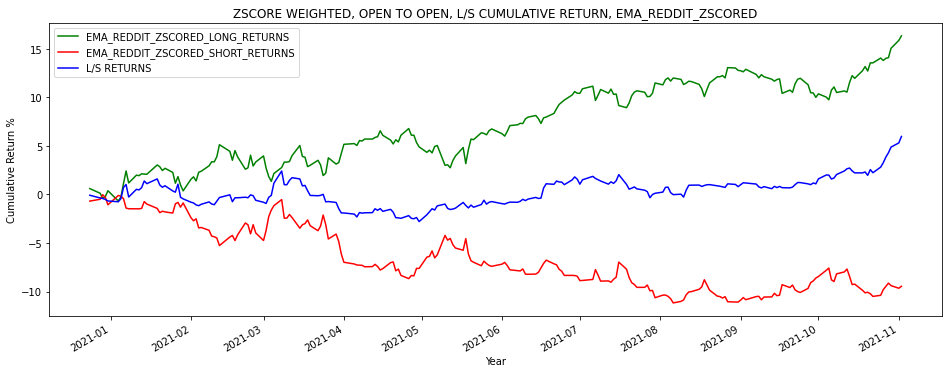

CAGR Ann. Vol Cumulative Ret.      MDD  \
EMA_REDDIT_ZSCORED_LONG_RETURNS    19.16%    9.31%          16.35%   -3.78%   
EMA_REDDIT_ZSCORED_SHORT_RETURNS  -10.87%    9.45%          -9.46%  -11.18%   
L/S RETURNS                         6.95%    6.13%           5.98%   -5.09%   

                                 Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_REDDIT_ZSCORED_LONG_RETURNS          1.93          2.86         5.06  
EMA_REDDIT_ZSCORED_SHORT_RETURNS        -1.17         -1.59        -0.97  
L/S RETURNS                              1.13          1.67         1.37

Nr of Trading Days, EMA_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_REDDIT_ZSCORED: 75


EMA_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 74.07 
 
 
 IT 
 65.28 
 
 
 MPWR 
 64.81 
 
 
 NVDA 
 60.19 
 
 
 ANSS 
 60.19 
 
 
 INTU 
 59.26 
 
 
 ADBE 
 58.33 
 
 
 SNPS 
 57.87 
 
 
 CDNS 
 57.41 
 
 
 CDW 
 56.94 
 
 
 
 
 
 
 EMA_REDDIT_ZSCORED SHORT % 
 
 
 
 
 FISV 
 67.59 
 
 
 FLT 
 64.35 
 
 
 CSCO 
 63.89 
 
 
 CTXS 
 63.43 
 
 
 FIS 
 62.04 
 
 
 GPN 
 61.57 
 
 
 WDC 
 61.11 
 
 
 WU 
 60.65 
 
 
 CTSH 
 60.19 
 
 
 ADP 
 60.19

Mean Turnover, Long Basket, All days, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_REDDIT_ZSCORED: 0.19


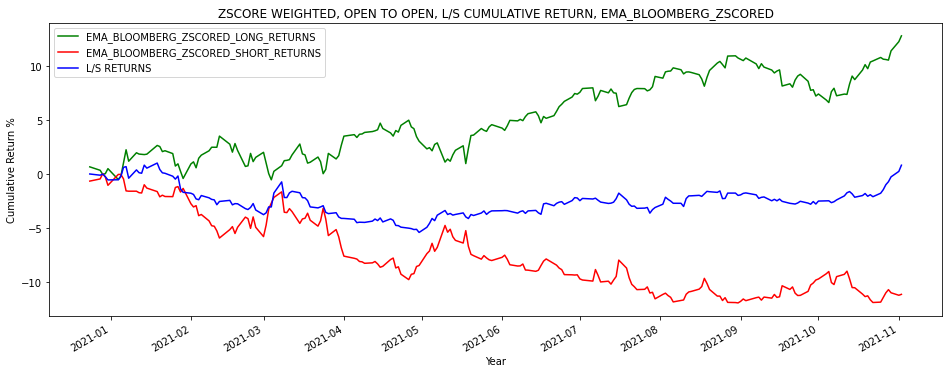

CAGR Ann. Vol Cumulative Ret.  \
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS    14.95%    8.82%          12.79%   
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS  -12.79%     9.4%         -11.15%   
L/S RETURNS                            0.94%    5.48%           0.81%   

                                         MDD Sharpe Ratio Sortino Ratio  \
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS    -3.91%         1.62          2.38   
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS  -11.97%        -1.41          -1.9   
L/S RETURNS                           -6.36%          0.2          0.29   

                                    Calmar Ratio  
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS          3.82  
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS        -1.07  
L/S RETURNS                                 0.15

Nr of Trading Days, EMA_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_BLOOMBERG_ZSCORED: 75


EMA_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 70.37 
 
 
 IT 
 61.11 
 
 
 MPWR 
 60.19 
 
 
 INTU 
 59.26 
 
 
 XLNX 
 56.94 
 
 
 CDW 
 56.94 
 
 
 CDNS 
 56.02 
 
 
 CDAY 
 55.56 
 
 
 NVDA 
 55.09 
 
 
 NOW 
 55.09 
 
 
 
 
 
 
 EMA_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 60.19 
 
 
 CTSH 
 58.80 
 
 
 GPN 
 58.33 
 
 
 INTC 
 56.02 
 
 
 AKAM 
 55.56 
 
 
 FLT 
 55.56 
 
 
 MA 
 55.09 
 
 
 HPQ 
 55.09 
 
 
 IBM 
 54.63 
 
 
 CSCO 
 54.17

Mean Turnover, Long Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2


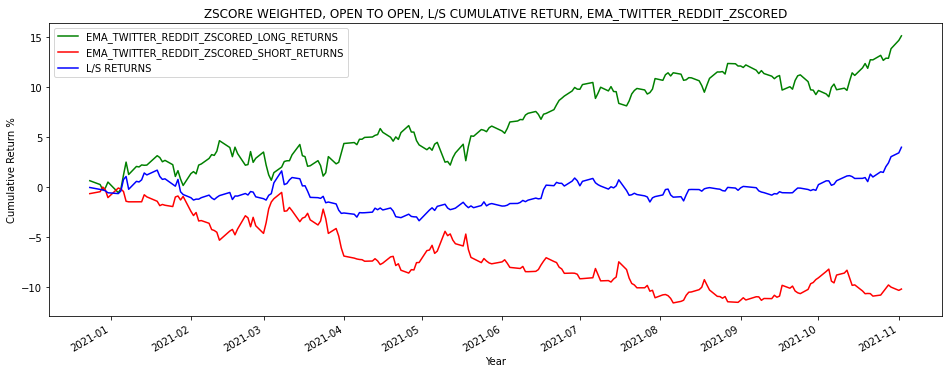

CAGR Ann. Vol Cumulative Ret.  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS    17.68%    9.28%           15.1%   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  -11.73%    9.35%         -10.22%   
L/S RETURNS                                  4.6%    5.96%           3.96%   

                                              MDD Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS    -3.78%          1.8          2.65   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  -11.61%        -1.29         -1.75   
L/S RETURNS                                -4.98%         0.78          1.14   

                                         Calmar Ratio  
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS          4.67  
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS        -1.01  
L/S RETURNS                                      0.92

Nr of Trading Days, EMA_TWITTER_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_ZSCORED: 75


EMA_TWITTER_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 74.07 
 
 
 MPWR 
 65.28 
 
 
 IT 
 64.35 
 
 
 INTU 
 60.65 
 
 
 ANSS 
 60.19 
 
 
 SNPS 
 59.26 
 
 
 NVDA 
 59.26 
 
 
 CDNS 
 58.80 
 
 
 HPQ 
 58.80 
 
 
 KEYS 
 58.33 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_ZSCORED SHORT % 
 
 
 
 
 FISV 
 67.13 
 
 
 FLT 
 65.28 
 
 
 ADP 
 63.43 
 
 
 CTXS 
 63.43 
 
 
 FIS 
 62.04 
 
 
 GPN 
 61.57 
 
 
 WU 
 60.65 
 
 
 WDC 
 60.65 
 
 
 CTSH 
 59.72 
 
 
 CSCO 
 59.72

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.19


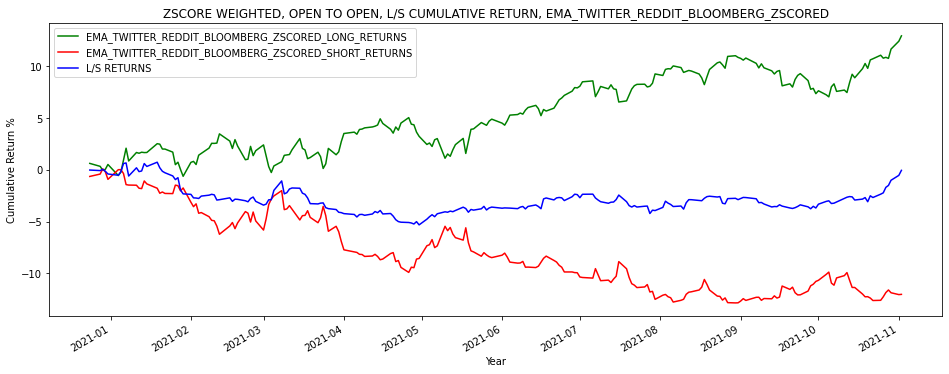

CAGR Ann. Vol  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS     15.1%    8.94%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS  -13.77%    9.15%   
L/S RETURNS                                          -0.06%    5.14%   

                                                   Cumulative Ret.      MDD  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS           12.92%   -3.73%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS         -12.01%  -12.92%   
L/S RETURNS                                                 -0.05%    -6.0%   

                                                   Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS          1.62          2.35   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS        -1.57         -2.11   
L/S RETURNS                                                0.01          0.02   

                                                   Calmar Ratio  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS          4.05  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS        -1.07  
L/S RETURNS                                               -0.01

Nr of Trading Days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 75


EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 73.15 
 
 
 IT 
 62.96 
 
 
 MPWR 
 61.11 
 
 
 AVGO 
 57.41 
 
 
 NVDA 
 56.94 
 
 
 TER 
 56.48 
 
 
 CDW 
 56.48 
 
 
 MSFT 
 55.56 
 
 
 CDAY 
 55.56 
 
 
 CDNS 
 55.09 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 ADP 
 62.04 
 
 
 CTSH 
 61.11 
 
 
 CTXS 
 60.65 
 
 
 WDC 
 60.19 
 
 
 FLT 
 58.80 
 
 
 FISV 
 58.33 
 
 
 GPN 
 58.33 
 
 
 IBM 
 56.94 
 
 
 WU 
 55.56 
 
 
 FFIV 
 55.09

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2


In [21]:
zscore_returns = []

for i in signal_df_list:
    
    STRATEGY_RETURNS, LS_RETURNS, DIAGNOSTICS_DF = backtest_minmax(
                                                                     signal_df              = i,
                                                                     returns_df             = returns_df ,
                                                                     upper_q                = upper_q,
                                                                     lower_q                = lower_q,
                                                                     min_stocks_each_basket = min_stocks_each_basket,
                                                                     extra_weight           = extra_weight
                                                        )
    
    zscore_returns.append(STRATEGY_RETURNS)

    LS_RETURNS['L/S RETURNS'] = LS_RETURNS.sum(axis=1)

    fig, ax = plt.subplots(figsize=(16,6))

    cum = cum_returns(LS_RETURNS)*100

    cum.plot(ax=ax,color = ['green','red','blue'])                               

    ax.legend(cum.columns,loc=2)
    plt.ylabel('Cumulative Return %')
    plt.xlabel('Year')
    ax.set_title('ZSCORE WEIGHTED, OPEN TO OPEN, L/S CUMULATIVE RETURN, '+str(STRATEGY_RETURNS.columns[0]))
    plt.show()
    display(backtest_metrics(LS_RETURNS))
    nr_of_trading_days(STRATEGY_RETURNS)
    total_number_of_trading_stocks(DIAGNOSTICS_DF)
    stats_long_short(DIAGNOSTICS_DF)
    top_10_stocks_traded(DIAGNOSTICS_DF)
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='NO')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='NO')

TWITTER    REDDIT  BLOOMBERG  EMA_ZSCORED  EQUAL_RETURNS  \
TWITTER        1.000000  0.148660   0.088937    -0.050589       0.031979   
REDDIT         0.148660  1.000000   0.013138    -0.042018       0.089272   
BLOOMBERG      0.088937  0.013138   1.000000     0.182449      -0.057947   
EMA_ZSCORED   -0.050589 -0.042018   0.182449     1.000000      -0.104493   
EQUAL_RETURNS  0.031979  0.089272  -0.057947    -0.104493       1.000000   
XLK_RETURNS    0.049236  0.089049   0.015781    -0.081439       0.884616   

               XLK_RETURNS  
TWITTER           0.049236  
REDDIT            0.089049  
BLOOMBERG         0.015781  
EMA_ZSCORED      -0.081439  
EQUAL_RETURNS     0.884616  
XLK_RETURNS       1.000000

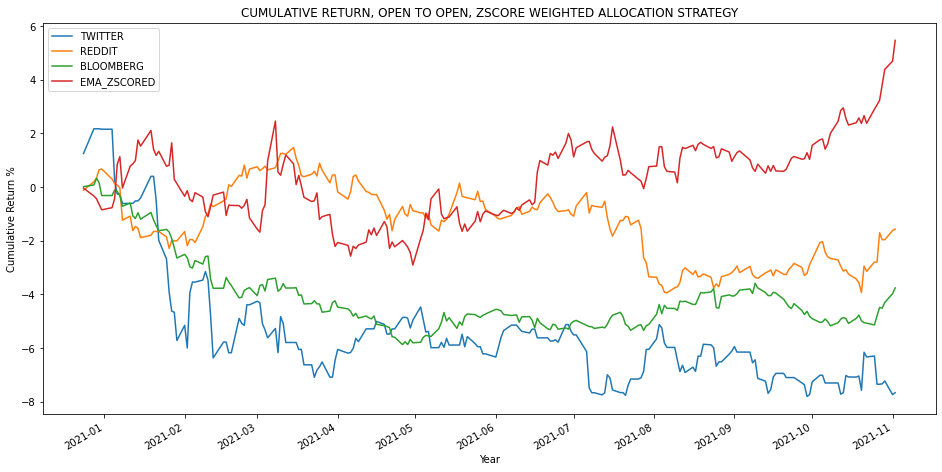

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
TWITTER      -8.82%    7.88%          -7.67%  -9.77%        -1.13   
REDDIT       -1.81%     4.9%          -1.57%  -5.35%        -0.35   
BLOOMBERG    -4.34%    3.41%          -3.76%  -6.19%        -1.28   
EMA_ZSCORED   6.36%    7.08%           5.47%  -5.24%         0.91   

            Sortino Ratio Calmar Ratio  
TWITTER             -1.51         -0.9  
REDDIT              -0.48        -0.34  
BLOOMBERG           -1.66         -0.7  
EMA_ZSCORED          1.32         1.21

In [22]:
singles = zscore_returns[0:4]
singles_corr = pd.concat(singles,axis=1)
singles_corr = pd.concat([singles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(singles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(singles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN, OPEN TO OPEN, ZSCORE WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(singles,axis=1)))

TWITTER_REDDIT_BLOOMBERG  \
TWITTER_REDDIT_BLOOMBERG                              1.000000   
EMA_TWITTER_ZSCORED                                   0.182341   
EMA_REDDIT_ZSCORED                                    0.262747   
EMA_BLOOMBERG_ZSCORED                                 0.423179   
EMA_TWITTER_REDDIT_ZSCORED                            0.311760   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                  0.608624   
EQUAL_RETURNS                                         0.013642   
XLK_RETURNS                                           0.073770   

                                      EMA_TWITTER_ZSCORED  EMA_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                         0.182341            0.262747   
EMA_TWITTER_ZSCORED                              1.000000            0.937127   
EMA_REDDIT_ZSCORED                               0.937127            1.000000   
EMA_BLOOMBERG_ZSCORED                            0.888453            0.874821   
EMA_TWITTER_REDDIT_ZSCORED                       0.951449            0.980842   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED             0.856292            0.887794   
EQUAL_RETURNS                                   -0.080708           -0.051168   
XLK_RETURNS                                     -0.059400           -0.022386   

                                      EMA_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                           0.423179   
EMA_TWITTER_ZSCORED                                0.888453   
EMA_REDDIT_ZSCORED                                 0.874821   
EMA_BLOOMBERG_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_ZSCORED                         0.852819   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED               0.938048   
EQUAL_RETURNS                                     -0.102082   
XLK_RETURNS                                       -0.058169   

                                      EMA_TWITTER_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                0.311760   
EMA_TWITTER_ZSCORED                                     0.951449   
EMA_REDDIT_ZSCORED                                      0.980842   
EMA_BLOOMBERG_ZSCORED                                   0.852819   
EMA_TWITTER_REDDIT_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                    0.900087   
EQUAL_RETURNS                                          -0.025754   
XLK_RETURNS                                            -0.003064   

                                      EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                          0.608624   
EMA_TWITTER_ZSCORED                                               0.856292   
EMA_REDDIT_ZSCORED                                                0.887794   
EMA_BLOOMBERG_ZSCORED                                             0.938048   
EMA_TWITTER_REDDIT_ZSCORED                                        0.900087   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                              1.000000   
EQUAL_RETURNS                                                    -0.041125   
XLK_RETURNS                                                       0.004678   

                                      EQUAL_RETURNS  XLK_RETURNS  
TWITTER_REDDIT_BLOOMBERG                   0.013642     0.073770  
EMA_TWITTER_ZSCORED                       -0.080708    -0.059400  
EMA_REDDIT_ZSCORED                        -0.051168    -0.022386  
EMA_BLOOMBERG_ZSCORED                     -0.102082    -0.058169  
EMA_TWITTER_REDDIT_ZSCORED                -0.025754    -0.003064  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED      -0.041125     0.004678  
EQUAL_RETURNS                              1.000000     0.884616  
XLK_RETURNS                                0.884616     1.000000

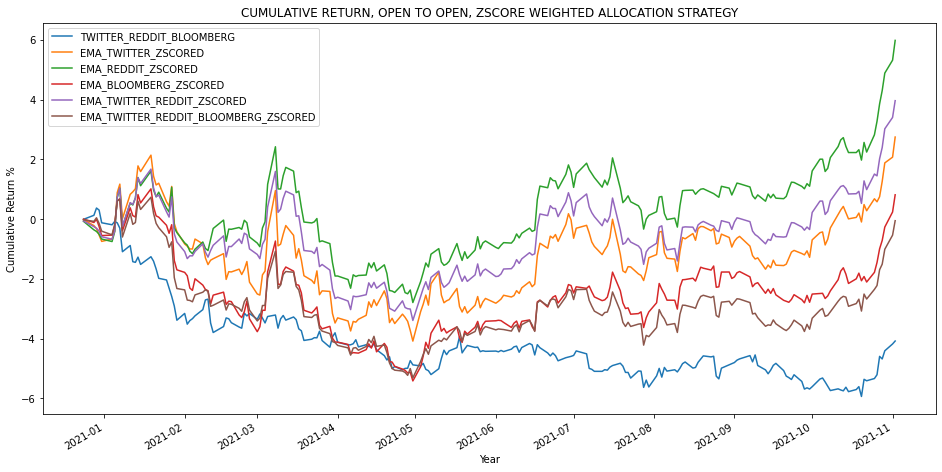

CAGR Ann. Vol Cumulative Ret.     MDD  \
TWITTER_REDDIT_BLOOMBERG              -4.71%    3.58%          -4.08%  -6.28%   
EMA_TWITTER_ZSCORED                    3.18%    6.68%           2.74%  -6.09%   
EMA_REDDIT_ZSCORED                     6.95%    6.13%           5.98%  -5.09%   
EMA_BLOOMBERG_ZSCORED                  0.94%    5.48%           0.81%  -6.36%   
EMA_TWITTER_REDDIT_ZSCORED              4.6%    5.96%           3.96%  -4.98%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED  -0.06%    5.14%          -0.05%   -6.0%   

                                     Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG                    -1.33         -1.68        -0.75  
EMA_TWITTER_ZSCORED                           0.5          0.71         0.52  
EMA_REDDIT_ZSCORED                           1.13          1.67         1.37  
EMA_BLOOMBERG_ZSCORED                         0.2          0.29         0.15  
EMA_TWITTER_REDDIT_ZSCORED                   0.78          1.14         0.92  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED         0.01          0.02        -0.01

In [23]:
doubles = zscore_returns[5:]

doubles_corr = pd.concat(doubles,axis=1)
doubles_corr = pd.concat([doubles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(doubles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(doubles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN, OPEN TO OPEN, ZSCORE WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(doubles,axis=1)))

# RANK WEIGHTED

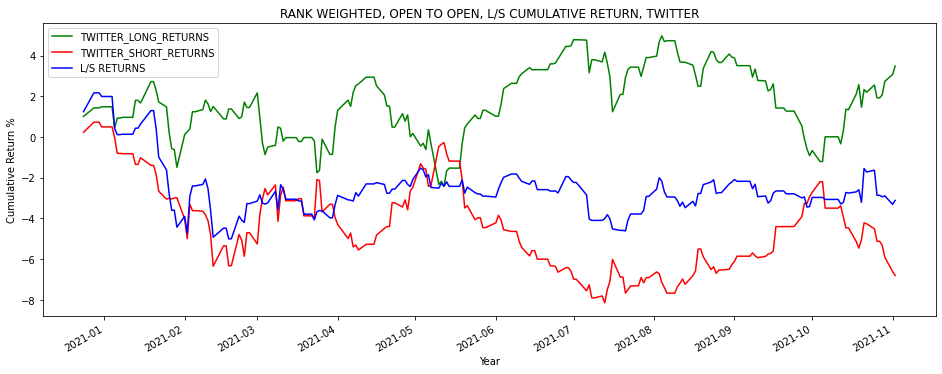

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
TWITTER_LONG_RETURNS    4.05%    8.68%           3.49%  -5.88%          0.5   
TWITTER_SHORT_RETURNS  -7.83%    8.99%           -6.8%  -8.82%        -0.86   
L/S RETURNS            -3.59%    7.23%          -3.11%  -7.02%        -0.47   

                      Sortino Ratio Calmar Ratio  
TWITTER_LONG_RETURNS            0.7         0.69  
TWITTER_SHORT_RETURNS         -1.23        -0.89  
L/S RETURNS                   -0.65        -0.51

Nr of Trading Days, TWITTER :75.93%
Total Nr of stocks trading, TWITTER: 24


TWITTER LONG % 
 
 
 
 
 MSFT 
 54.88 
 
 
 QCOM 
 53.05 
 
 
 AAPL 
 51.22 
 
 
 ADP 
 50.00 
 
 
 LRCX 
 49.39 
 
 
 INTC 
 42.68 
 
 
 CSCO 
 42.68 
 
 
 TER 
 41.46 
 
 
 NVDA 
 40.85 
 
 
 ADI 
 35.98 
 
 
 
 
 
 
 TWITTER SHORT % 
 
 
 
 
 NVDA 
 53.66 
 
 
 INTC 
 53.05 
 
 
 ADBE 
 51.22 
 
 
 PYPL 
 49.39 
 
 
 TER 
 46.95 
 
 
 ADP 
 46.34 
 
 
 AAPL 
 44.51 
 
 
 MSFT 
 42.07 
 
 
 ADI 
 40.24 
 
 
 CRM 
 36.59

Mean Turnover, Long Basket, All days, TWITTER: 0.45
Mean Turnover, Short Basket, All days, TWITTER: 0.44
Mean Turnover, Long Basket, trading days only, TWITTER: 0.17
Mean Turnover, Short Basket, trading days only, TWITTER: 0.16


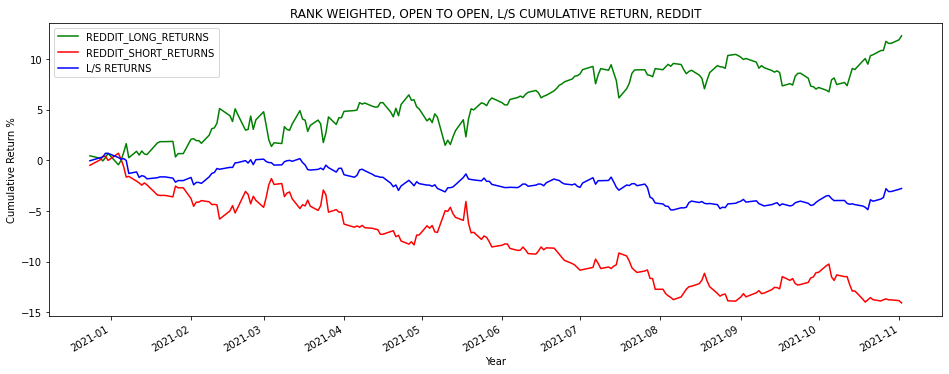

CAGR Ann. Vol Cumulative Ret.      MDD Sharpe Ratio  \
REDDIT_LONG_RETURNS    14.35%    10.4%          12.28%   -4.67%         1.34   
REDDIT_SHORT_RETURNS  -16.09%    9.44%         -14.07%  -14.67%        -1.81   
L/S RETURNS             -3.2%    4.75%          -2.78%   -5.55%        -0.66   

                     Sortino Ratio Calmar Ratio  
REDDIT_LONG_RETURNS           1.91         3.07  
REDDIT_SHORT_RETURNS         -2.43         -1.1  
L/S RETURNS                   -0.9        -0.58

Nr of Trading Days, REDDIT :95.83%
Total Nr of stocks trading, REDDIT: 50


REDDIT LONG % 
 
 
 
 
 FTNT 
 77.78 
 
 
 MSI 
 57.97 
 
 
 INTC 
 53.14 
 
 
 CRM 
 52.66 
 
 
 TER 
 51.69 
 
 
 AMD 
 51.69 
 
 
 AVGO 
 51.21 
 
 
 ENPH 
 51.21 
 
 
 TDY 
 50.72 
 
 
 MU 
 50.24 
 
 
 
 
 
 
 REDDIT SHORT % 
 
 
 
 
 ADP 
 62.32 
 
 
 PYPL 
 59.42 
 
 
 AAPL 
 56.52 
 
 
 CSCO 
 56.04 
 
 
 HPE 
 55.07 
 
 
 LRCX 
 53.62 
 
 
 WDC 
 53.62 
 
 
 IBM 
 52.66 
 
 
 ORCL 
 52.17 
 
 
 XLNX 
 50.72

Mean Turnover, Long Basket, All days, REDDIT: 0.22
Mean Turnover, Short Basket, All days, REDDIT: 0.22
Mean Turnover, Long Basket, trading days only, REDDIT: 0.17
Mean Turnover, Short Basket, trading days only, REDDIT: 0.17


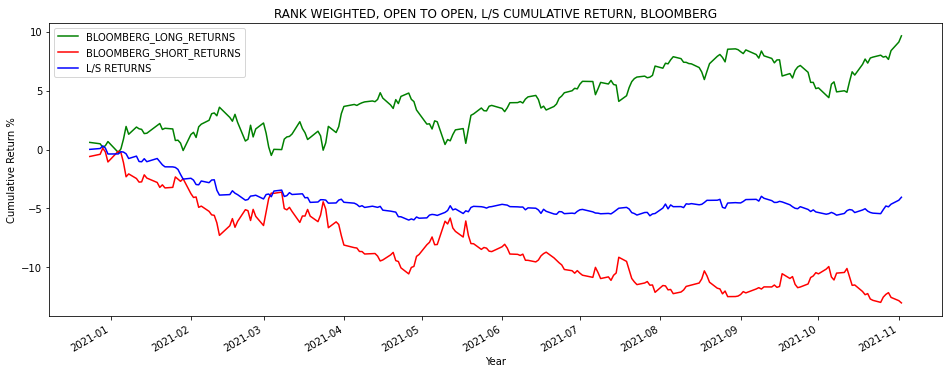

CAGR Ann. Vol Cumulative Ret.      MDD  \
BLOOMBERG_LONG_RETURNS    11.26%    8.56%           9.65%   -4.19%   
BLOOMBERG_SHORT_RETURNS  -14.92%    8.85%         -13.03%  -13.12%   
L/S RETURNS               -4.68%    3.53%          -4.05%   -6.28%   

                        Sharpe Ratio Sortino Ratio Calmar Ratio  
BLOOMBERG_LONG_RETURNS          1.29          1.86         2.68  
BLOOMBERG_SHORT_RETURNS        -1.78         -2.41        -1.14  
L/S RETURNS                    -1.34         -1.72        -0.74

Nr of Trading Days, BLOOMBERG :100.0%
Total Nr of stocks trading, BLOOMBERG: 75


BLOOMBERG LONG % 
 
 
 
 
 MA 
 58.80 
 
 
 ENPH 
 58.33 
 
 
 FTNT 
 57.87 
 
 
 V 
 55.56 
 
 
 NVDA 
 55.09 
 
 
 NOW 
 54.63 
 
 
 TER 
 53.70 
 
 
 FISV 
 53.24 
 
 
 INTU 
 53.24 
 
 
 INTC 
 53.24 
 
 
 
 
 
 
 BLOOMBERG SHORT % 
 
 
 
 
 ANSS 
 57.41 
 
 
 KEYS 
 56.48 
 
 
 JKHY 
 55.09 
 
 
 BR 
 54.63 
 
 
 PTC 
 54.63 
 
 
 ADSK 
 54.63 
 
 
 NLOK 
 54.17 
 
 
 HPE 
 53.24 
 
 
 IPGP 
 53.24 
 
 
 TEL 
 53.24

Mean Turnover, Long Basket, All days, BLOOMBERG: 0.19
Mean Turnover, Short Basket, All days, BLOOMBERG: 0.2
Mean Turnover, Long Basket, trading days only, BLOOMBERG: 0.19
Mean Turnover, Short Basket, trading days only, BLOOMBERG: 0.2


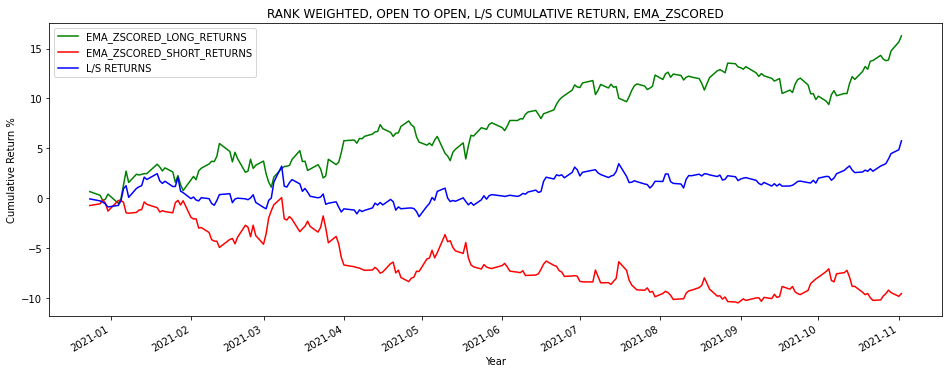

CAGR Ann. Vol Cumulative Ret.      MDD  \
EMA_ZSCORED_LONG_RETURNS    19.07%     9.1%          16.28%   -4.16%   
EMA_ZSCORED_SHORT_RETURNS  -10.98%    9.82%          -9.56%  -10.55%   
L/S RETURNS                  6.68%    7.23%           5.75%   -4.91%   

                          Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_ZSCORED_LONG_RETURNS          1.96          2.96         4.59  
EMA_ZSCORED_SHORT_RETURNS        -1.13         -1.53        -1.04  
L/S RETURNS                       0.93          1.36         1.36

Nr of Trading Days, EMA_ZSCORED :100.0%
Total Nr of stocks trading, EMA_ZSCORED: 75


EMA_ZSCORED LONG % 
 
 
 
 
 FTNT 
 77.31 
 
 
 INTU 
 66.67 
 
 
 MPWR 
 64.35 
 
 
 IT 
 62.96 
 
 
 KEYS 
 60.65 
 
 
 ZBRA 
 59.26 
 
 
 SNPS 
 59.26 
 
 
 CRM 
 58.80 
 
 
 ANSS 
 58.33 
 
 
 NVDA 
 58.33 
 
 
 
 
 
 
 EMA_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 64.81 
 
 
 WU 
 64.81 
 
 
 GPN 
 62.50 
 
 
 FIS 
 62.50 
 
 
 FISV 
 62.50 
 
 
 GLW 
 61.57 
 
 
 CTSH 
 61.11 
 
 
 FLT 
 61.11 
 
 
 IBM 
 59.72 
 
 
 AKAM 
 59.26

Mean Turnover, Long Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_ZSCORED: 0.19


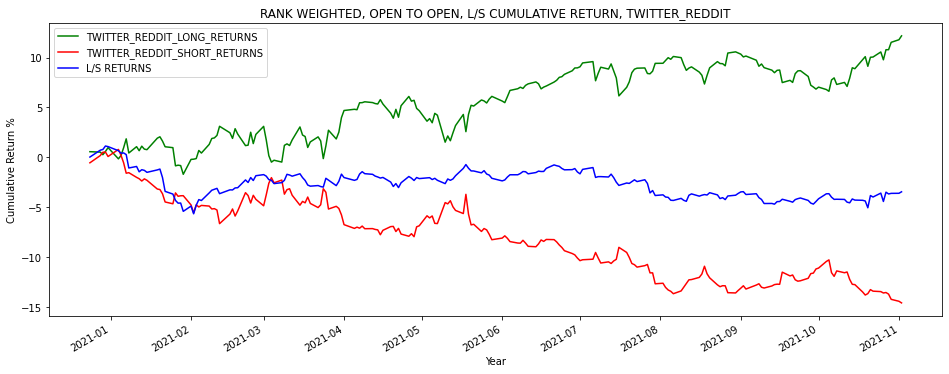

CAGR Ann. Vol Cumulative Ret.      MDD  \
TWITTER_REDDIT_LONG_RETURNS    14.21%   10.77%          12.17%   -4.31%   
TWITTER_REDDIT_SHORT_RETURNS  -16.65%     9.6%         -14.56%  -15.24%   
L/S RETURNS                    -3.97%    5.95%          -3.44%   -6.71%   

                             Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_LONG_RETURNS          1.29          1.83          3.3  
TWITTER_REDDIT_SHORT_RETURNS        -1.85         -2.52        -1.09  
L/S RETURNS                         -0.65         -0.89        -0.59

Nr of Trading Days, TWITTER_REDDIT :100.0%
Total Nr of stocks trading, TWITTER_REDDIT: 52


TWITTER_REDDIT LONG % 
 
 
 
 
 FTNT 
 64.35 
 
 
 CRM 
 53.70 
 
 
 TER 
 53.24 
 
 
 MSFT 
 50.93 
 
 
 AMD 
 49.07 
 
 
 SWKS 
 49.07 
 
 
 BR 
 49.07 
 
 
 MU 
 48.61 
 
 
 NVDA 
 48.61 
 
 
 INTC 
 47.22 
 
 
 
 
 
 
 TWITTER_REDDIT SHORT % 
 
 
 
 
 ORCL 
 57.41 
 
 
 ADP 
 56.94 
 
 
 PYPL 
 55.56 
 
 
 IBM 
 52.31 
 
 
 AAPL 
 51.85 
 
 
 INTC 
 51.85 
 
 
 WDC 
 49.54 
 
 
 QCOM 
 49.54 
 
 
 MSFT 
 49.07 
 
 
 ADBE 
 49.07

Mean Turnover, Long Basket, All days, TWITTER_REDDIT: 0.24
Mean Turnover, Short Basket, All days, TWITTER_REDDIT: 0.21
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT: 0.24
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT: 0.21


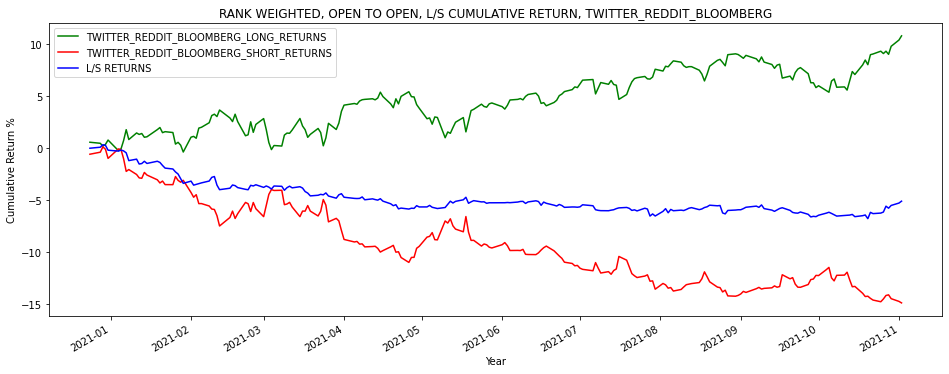

CAGR Ann. Vol Cumulative Ret.  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS    12.62%    8.85%          10.81%   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -17.01%    8.77%         -14.88%   
L/S RETURNS                              -5.87%    3.63%          -5.09%   

                                            MDD Sharpe Ratio Sortino Ratio  \
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS     -4.2%         1.39           2.0   
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS  -14.99%        -2.08         -2.75   
L/S RETURNS                              -7.09%        -1.65         -2.04   

                                       Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG_LONG_RETURNS          3.01  
TWITTER_REDDIT_BLOOMBERG_SHORT_RETURNS        -1.13  
L/S RETURNS                                   -0.83

Nr of Trading Days, TWITTER_REDDIT_BLOOMBERG :100.0%
Total Nr of stocks trading, TWITTER_REDDIT_BLOOMBERG: 75


TWITTER_REDDIT_BLOOMBERG LONG % 
 
 
 
 
 FTNT 
 62.96 
 
 
 TER 
 58.33 
 
 
 AVGO 
 57.87 
 
 
 QCOM 
 57.87 
 
 
 MA 
 57.41 
 
 
 MSFT 
 56.02 
 
 
 SWKS 
 55.56 
 
 
 NXPI 
 55.56 
 
 
 V 
 55.09 
 
 
 NOW 
 55.09 
 
 
 
 
 
 
 TWITTER_REDDIT_BLOOMBERG SHORT % 
 
 
 
 
 PAYX 
 58.80 
 
 
 TRMB 
 58.80 
 
 
 KEYS 
 58.33 
 
 
 ADP 
 57.41 
 
 
 ADSK 
 56.94 
 
 
 ANSS 
 56.94 
 
 
 NLOK 
 56.48 
 
 
 BR 
 56.02 
 
 
 WDC 
 55.56 
 
 
 PTC 
 55.09

Mean Turnover, Long Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Short Basket, All days, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Long Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.21
Mean Turnover, Short Basket, trading days only, TWITTER_REDDIT_BLOOMBERG: 0.21


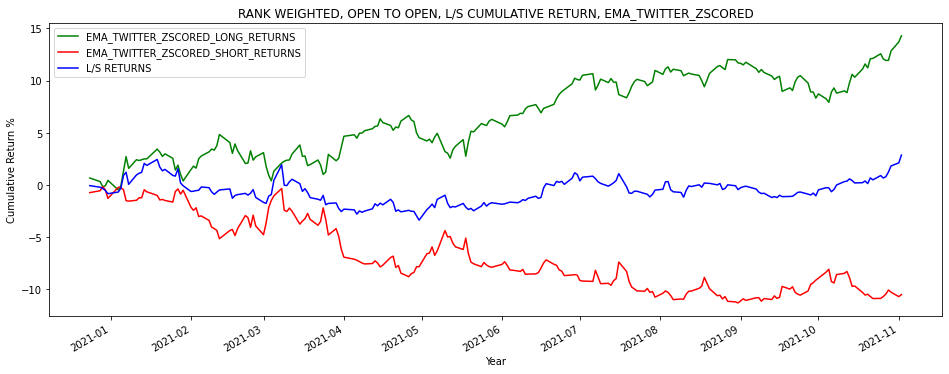

CAGR Ann. Vol Cumulative Ret.     MDD  \
EMA_TWITTER_ZSCORED_LONG_RETURNS    16.72%    9.11%          14.29%  -4.23%   
EMA_TWITTER_ZSCORED_SHORT_RETURNS  -12.05%    9.69%          -10.5%  -11.3%   
L/S RETURNS                          3.33%    6.87%           2.87%  -5.68%   

                                  Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_TWITTER_ZSCORED_LONG_RETURNS          1.74          2.59         3.95  
EMA_TWITTER_ZSCORED_SHORT_RETURNS        -1.28         -1.72        -1.07  
L/S RETURNS                               0.51          0.72         0.59

Nr of Trading Days, EMA_TWITTER_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_ZSCORED: 75


EMA_TWITTER_ZSCORED LONG % 
 
 
 
 
 FTNT 
 76.85 
 
 
 MPWR 
 65.28 
 
 
 INTU 
 65.28 
 
 
 IT 
 62.50 
 
 
 KEYS 
 61.57 
 
 
 SNPS 
 60.65 
 
 
 CDNS 
 59.26 
 
 
 ANSS 
 58.80 
 
 
 MSI 
 58.33 
 
 
 CDW 
 57.87 
 
 
 
 
 
 
 EMA_TWITTER_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 64.35 
 
 
 WU 
 62.50 
 
 
 GPN 
 62.04 
 
 
 FISV 
 62.04 
 
 
 FIS 
 61.57 
 
 
 QCOM 
 60.65 
 
 
 FLT 
 60.19 
 
 
 GLW 
 59.72 
 
 
 CTSH 
 59.72 
 
 
 INTC 
 58.33

Mean Turnover, Long Basket, All days, EMA_TWITTER_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_TWITTER_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_ZSCORED: 0.2


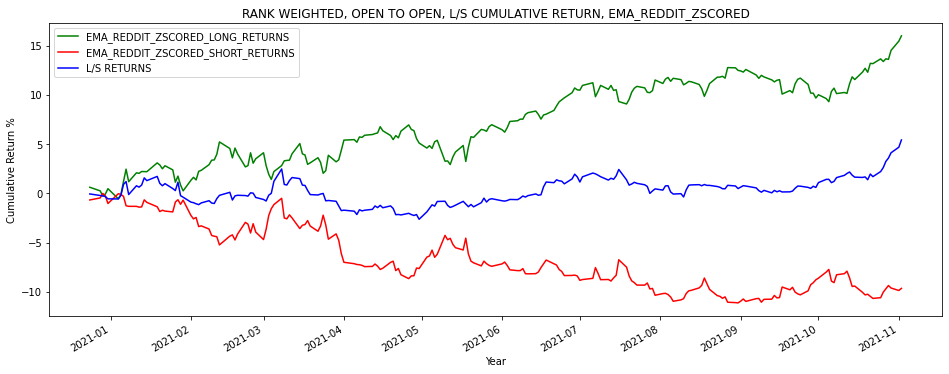

CAGR Ann. Vol Cumulative Ret.      MDD  \
EMA_REDDIT_ZSCORED_LONG_RETURNS    18.72%    9.29%          15.98%   -3.77%   
EMA_REDDIT_ZSCORED_SHORT_RETURNS  -11.09%    9.46%          -9.65%  -11.13%   
L/S RETURNS                         6.29%    6.19%           5.42%   -4.98%   

                                 Sharpe Ratio Sortino Ratio Calmar Ratio  
EMA_REDDIT_ZSCORED_LONG_RETURNS          1.89           2.8         4.97  
EMA_REDDIT_ZSCORED_SHORT_RETURNS         -1.2         -1.62         -1.0  
L/S RETURNS                              1.02          1.49         1.26

Nr of Trading Days, EMA_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_REDDIT_ZSCORED: 75


EMA_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 74.07 
 
 
 IT 
 65.28 
 
 
 MPWR 
 64.81 
 
 
 NVDA 
 60.19 
 
 
 ANSS 
 60.19 
 
 
 INTU 
 59.26 
 
 
 ADBE 
 58.33 
 
 
 SNPS 
 57.87 
 
 
 CDNS 
 57.41 
 
 
 CDW 
 56.94 
 
 
 
 
 
 
 EMA_REDDIT_ZSCORED SHORT % 
 
 
 
 
 FISV 
 67.59 
 
 
 FLT 
 64.35 
 
 
 CSCO 
 63.89 
 
 
 CTXS 
 63.43 
 
 
 FIS 
 62.04 
 
 
 GPN 
 61.57 
 
 
 WDC 
 61.11 
 
 
 WU 
 60.65 
 
 
 CTSH 
 60.19 
 
 
 ADP 
 60.19

Mean Turnover, Long Basket, All days, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_REDDIT_ZSCORED: 0.19


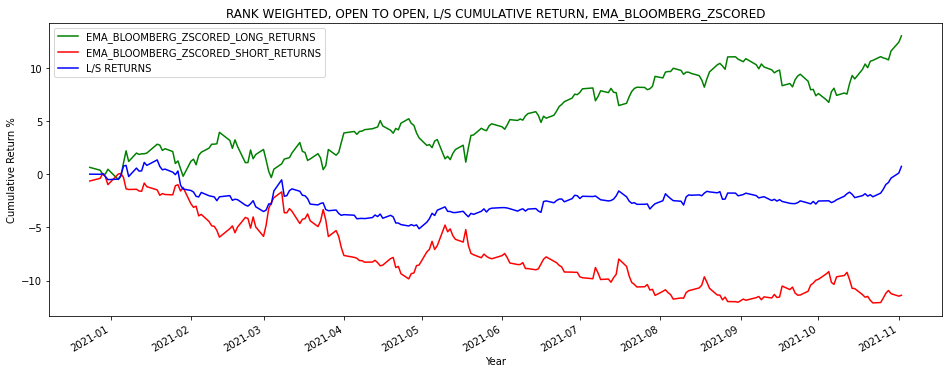

CAGR Ann. Vol Cumulative Ret.  \
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS    15.21%    8.79%          13.01%   
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS  -13.05%    9.42%         -11.38%   
L/S RETURNS                            0.85%     5.6%           0.74%   

                                         MDD Sharpe Ratio Sortino Ratio  \
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS    -4.09%         1.65          2.44   
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS  -12.16%        -1.44         -1.93   
L/S RETURNS                           -6.39%         0.18          0.26   

                                    Calmar Ratio  
EMA_BLOOMBERG_ZSCORED_LONG_RETURNS          3.72  
EMA_BLOOMBERG_ZSCORED_SHORT_RETURNS        -1.07  
L/S RETURNS                                 0.13

Nr of Trading Days, EMA_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_BLOOMBERG_ZSCORED: 75


EMA_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 70.37 
 
 
 IT 
 61.11 
 
 
 MPWR 
 60.19 
 
 
 INTU 
 59.26 
 
 
 XLNX 
 56.94 
 
 
 CDW 
 56.94 
 
 
 CDNS 
 56.02 
 
 
 CDAY 
 55.56 
 
 
 NVDA 
 55.09 
 
 
 NOW 
 55.09 
 
 
 
 
 
 
 EMA_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 CTXS 
 60.19 
 
 
 CTSH 
 58.80 
 
 
 GPN 
 58.33 
 
 
 INTC 
 56.02 
 
 
 AKAM 
 55.56 
 
 
 FLT 
 55.56 
 
 
 MA 
 55.09 
 
 
 HPQ 
 55.09 
 
 
 IBM 
 54.63 
 
 
 CSCO 
 54.17

Mean Turnover, Long Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_BLOOMBERG_ZSCORED: 0.2


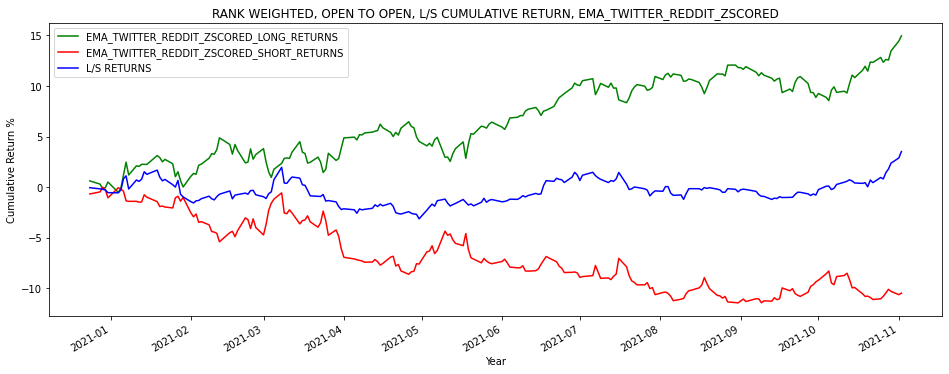

CAGR Ann. Vol Cumulative Ret.  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS     17.5%    9.26%          14.95%   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  -12.03%    9.37%         -10.48%   
L/S RETURNS                                 4.08%    6.13%           3.52%   

                                              MDD Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS    -3.73%         1.79          2.63   
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS  -11.44%        -1.32         -1.78   
L/S RETURNS                                -4.99%         0.68          0.98   

                                         Calmar Ratio  
EMA_TWITTER_REDDIT_ZSCORED_LONG_RETURNS          4.69  
EMA_TWITTER_REDDIT_ZSCORED_SHORT_RETURNS        -1.05  
L/S RETURNS                                      0.82

Nr of Trading Days, EMA_TWITTER_REDDIT_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_ZSCORED: 75


EMA_TWITTER_REDDIT_ZSCORED LONG % 
 
 
 
 
 FTNT 
 74.07 
 
 
 MPWR 
 65.28 
 
 
 IT 
 64.35 
 
 
 INTU 
 60.65 
 
 
 ANSS 
 60.19 
 
 
 SNPS 
 59.26 
 
 
 NVDA 
 59.26 
 
 
 CDNS 
 58.80 
 
 
 HPQ 
 58.80 
 
 
 KEYS 
 58.33 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_ZSCORED SHORT % 
 
 
 
 
 FISV 
 67.13 
 
 
 FLT 
 65.28 
 
 
 ADP 
 63.43 
 
 
 CTXS 
 63.43 
 
 
 FIS 
 62.04 
 
 
 GPN 
 61.57 
 
 
 WU 
 60.65 
 
 
 WDC 
 60.65 
 
 
 CTSH 
 59.72 
 
 
 CSCO 
 59.72

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_ZSCORED: 0.19
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.19
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_ZSCORED: 0.19


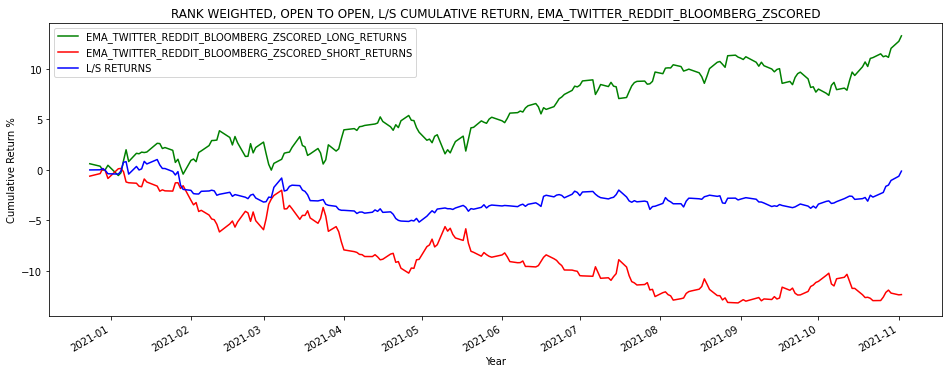

CAGR Ann. Vol  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS    15.52%    8.89%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS  -14.14%    9.16%   
L/S RETURNS                                          -0.13%    5.29%   

                                                   Cumulative Ret.      MDD  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS           13.27%   -3.75%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS         -12.34%  -13.29%   
L/S RETURNS                                                 -0.12%   -6.13%   

                                                   Sharpe Ratio Sortino Ratio  \
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS          1.67          2.43   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS        -1.62         -2.16   
L/S RETURNS                                                 0.0           0.0   

                                                   Calmar Ratio  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_LONG_RETURNS          4.14  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED_SHORT_RETURNS        -1.06  
L/S RETURNS                                               -0.02

Nr of Trading Days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED :100.0%
Total Nr of stocks trading, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 75


EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED LONG % 
 
 
 
 
 FTNT 
 73.15 
 
 
 IT 
 62.96 
 
 
 MPWR 
 61.11 
 
 
 AVGO 
 57.41 
 
 
 NVDA 
 56.94 
 
 
 TER 
 56.48 
 
 
 CDW 
 56.48 
 
 
 MSFT 
 55.56 
 
 
 CDAY 
 55.56 
 
 
 CDNS 
 55.09 
 
 
 
 
 
 
 EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED SHORT % 
 
 
 
 
 ADP 
 62.04 
 
 
 CTSH 
 61.11 
 
 
 CTXS 
 60.65 
 
 
 WDC 
 60.19 
 
 
 FLT 
 58.80 
 
 
 FISV 
 58.33 
 
 
 GPN 
 58.33 
 
 
 IBM 
 56.94 
 
 
 WU 
 55.56 
 
 
 FFIV 
 55.09

Mean Turnover, Long Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, All days, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Long Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2
Mean Turnover, Short Basket, trading days only, EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED: 0.2


In [24]:
zscore_returns = []

for i in signal_df_list:
    
    STRATEGY_RETURNS, LS_RETURNS, DIAGNOSTICS_DF = backtest_rank(
                                                                     signal_df              = i,
                                                                     returns_df             = returns_df ,
                                                                     upper_q                = upper_q,
                                                                     lower_q                = lower_q,
                                                                     min_stocks_each_basket = min_stocks_each_basket,
                                                                    
                                                        )
    
    zscore_returns.append(STRATEGY_RETURNS)

    LS_RETURNS['L/S RETURNS'] = LS_RETURNS.sum(axis=1)

    fig, ax = plt.subplots(figsize=(16,6))

    cum = cum_returns(LS_RETURNS)*100

    cum.plot(ax=ax,color = ['green','red','blue'])                               

    ax.legend(cum.columns,loc=2)
    plt.ylabel('Cumulative Return %')
    plt.xlabel('Year')
    ax.set_title('RANK WEIGHTED, OPEN TO OPEN, L/S CUMULATIVE RETURN, '+str(STRATEGY_RETURNS.columns[0]))
    plt.show()
    display(backtest_metrics(LS_RETURNS))
    nr_of_trading_days(STRATEGY_RETURNS)
    total_number_of_trading_stocks(DIAGNOSTICS_DF)
    stats_long_short(DIAGNOSTICS_DF)
    top_10_stocks_traded(DIAGNOSTICS_DF)
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='YES')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='LONG',ALL_DAYS='NO')
    turnover_holdings(STRATEGY_RETURNS,DIAGNOSTICS_DF,BASKET='SHORT',ALL_DAYS='NO')

TWITTER    REDDIT  BLOOMBERG  EMA_ZSCORED  EQUAL_RETURNS  \
TWITTER        1.000000  0.122079   0.108875    -0.031074      -0.003023   
REDDIT         0.122079  1.000000  -0.002140    -0.073286       0.122013   
BLOOMBERG      0.108875 -0.002140   1.000000     0.211883      -0.064226   
EMA_ZSCORED   -0.031074 -0.073286   0.211883     1.000000      -0.118616   
EQUAL_RETURNS -0.003023  0.122013  -0.064226    -0.118616       1.000000   
XLK_RETURNS    0.008719  0.124326   0.010375    -0.100553       0.884616   

               XLK_RETURNS  
TWITTER           0.008719  
REDDIT            0.124326  
BLOOMBERG         0.010375  
EMA_ZSCORED      -0.100553  
EQUAL_RETURNS     0.884616  
XLK_RETURNS       1.000000

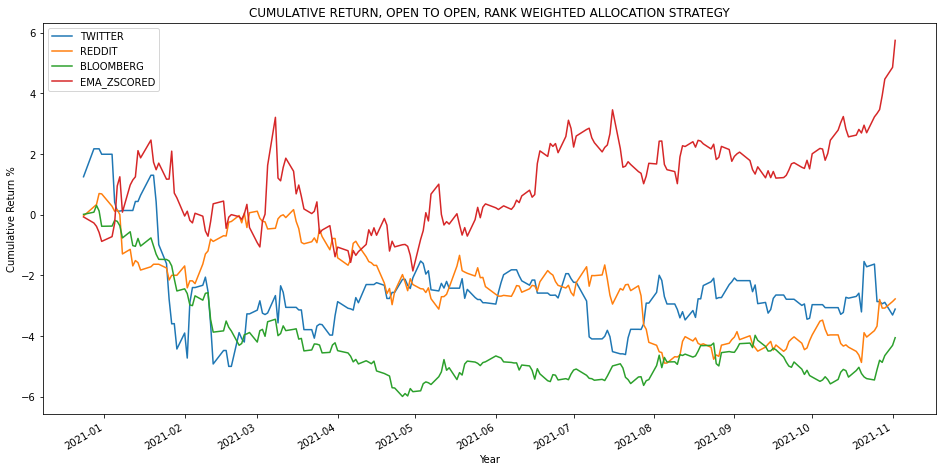

CAGR Ann. Vol Cumulative Ret.     MDD Sharpe Ratio  \
TWITTER      -3.59%    7.23%          -3.11%  -7.02%        -0.47   
REDDIT        -3.2%    4.75%          -2.78%  -5.55%        -0.66   
BLOOMBERG    -4.68%    3.53%          -4.05%  -6.28%        -1.34   
EMA_ZSCORED   6.68%    7.23%           5.75%  -4.91%         0.93   

            Sortino Ratio Calmar Ratio  
TWITTER             -0.65        -0.51  
REDDIT               -0.9        -0.58  
BLOOMBERG           -1.72        -0.74  
EMA_ZSCORED          1.36         1.36

In [25]:
singles = zscore_returns[0:4]

singles_corr = pd.concat(singles,axis=1)
singles_corr = pd.concat([singles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(singles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(singles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN, OPEN TO OPEN, RANK WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(singles,axis=1)))

TWITTER_REDDIT_BLOOMBERG  \
TWITTER_REDDIT_BLOOMBERG                              1.000000   
EMA_TWITTER_ZSCORED                                   0.177306   
EMA_REDDIT_ZSCORED                                    0.252672   
EMA_BLOOMBERG_ZSCORED                                 0.420991   
EMA_TWITTER_REDDIT_ZSCORED                            0.294444   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                  0.590171   
EQUAL_RETURNS                                         0.012485   
XLK_RETURNS                                           0.080570   

                                      EMA_TWITTER_ZSCORED  EMA_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                         0.177306            0.252672   
EMA_TWITTER_ZSCORED                              1.000000            0.932004   
EMA_REDDIT_ZSCORED                               0.932004            1.000000   
EMA_BLOOMBERG_ZSCORED                            0.886097            0.874335   
EMA_TWITTER_REDDIT_ZSCORED                       0.953224            0.981449   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED             0.863663            0.892822   
EQUAL_RETURNS                                   -0.091649           -0.055085   
XLK_RETURNS                                     -0.074418           -0.029645   

                                      EMA_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                           0.420991   
EMA_TWITTER_ZSCORED                                0.886097   
EMA_REDDIT_ZSCORED                                 0.874335   
EMA_BLOOMBERG_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_ZSCORED                         0.861153   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED               0.946377   
EQUAL_RETURNS                                     -0.102259   
XLK_RETURNS                                       -0.061492   

                                      EMA_TWITTER_REDDIT_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                0.294444   
EMA_TWITTER_ZSCORED                                     0.953224   
EMA_REDDIT_ZSCORED                                      0.981449   
EMA_BLOOMBERG_ZSCORED                                   0.861153   
EMA_TWITTER_REDDIT_ZSCORED                              1.000000   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                    0.906891   
EQUAL_RETURNS                                          -0.032236   
XLK_RETURNS                                            -0.011612   

                                      EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED  \
TWITTER_REDDIT_BLOOMBERG                                          0.590171   
EMA_TWITTER_ZSCORED                                               0.863663   
EMA_REDDIT_ZSCORED                                                0.892822   
EMA_BLOOMBERG_ZSCORED                                             0.946377   
EMA_TWITTER_REDDIT_ZSCORED                                        0.906891   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED                              1.000000   
EQUAL_RETURNS                                                    -0.041328   
XLK_RETURNS                                                       0.000962   

                                      EQUAL_RETURNS  XLK_RETURNS  
TWITTER_REDDIT_BLOOMBERG                   0.012485     0.080570  
EMA_TWITTER_ZSCORED                       -0.091649    -0.074418  
EMA_REDDIT_ZSCORED                        -0.055085    -0.029645  
EMA_BLOOMBERG_ZSCORED                     -0.102259    -0.061492  
EMA_TWITTER_REDDIT_ZSCORED                -0.032236    -0.011612  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED      -0.041328     0.000962  
EQUAL_RETURNS                              1.000000     0.884616  
XLK_RETURNS                                0.884616     1.000000

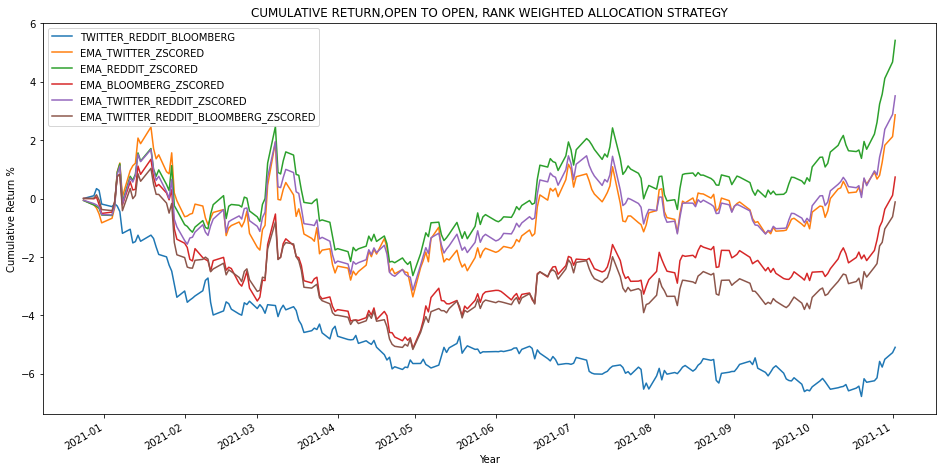

CAGR Ann. Vol Cumulative Ret.     MDD  \
TWITTER_REDDIT_BLOOMBERG              -5.87%    3.63%          -5.09%  -7.09%   
EMA_TWITTER_ZSCORED                    3.33%    6.87%           2.87%  -5.68%   
EMA_REDDIT_ZSCORED                     6.29%    6.19%           5.42%  -4.98%   
EMA_BLOOMBERG_ZSCORED                  0.85%     5.6%           0.74%  -6.39%   
EMA_TWITTER_REDDIT_ZSCORED             4.08%    6.13%           3.52%  -4.99%   
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED  -0.13%    5.29%          -0.12%  -6.13%   

                                     Sharpe Ratio Sortino Ratio Calmar Ratio  
TWITTER_REDDIT_BLOOMBERG                    -1.65         -2.04        -0.83  
EMA_TWITTER_ZSCORED                          0.51          0.72         0.59  
EMA_REDDIT_ZSCORED                           1.02          1.49         1.26  
EMA_BLOOMBERG_ZSCORED                        0.18          0.26         0.13  
EMA_TWITTER_REDDIT_ZSCORED                   0.68          0.98         0.82  
EMA_TWITTER_REDDIT_BLOOMBERG_ZSCORED          0.0           0.0        -0.02

In [26]:
doubles = zscore_returns[5:]

doubles_corr = pd.concat(doubles,axis=1)
doubles_corr = pd.concat([doubles_corr,
                          OPEN_TO_CLOSE_EQUALW_RETURNS.set_index('Date')[['EQUAL_RETURNS']],
                          OPEN_TO_CLOSE_XLK_RETURNS.set_index('Date')[['XLK_RETURNS']]],axis=1)

display(doubles_corr.corr())

fig, ax = plt.subplots(figsize=(16,8))

cum = cum_returns(pd.concat(doubles,axis=1))*100

cum.plot(ax=ax,)                               

ax.legend(cum.columns,loc=2)
plt.ylabel('Cumulative Return %')
plt.xlabel('Year')
ax.set_title('CUMULATIVE RETURN,OPEN TO OPEN, RANK WEIGHTED ALLOCATION STRATEGY')
plt.show()
display(backtest_metrics(pd.concat(doubles,axis=1)))